<a name="abstract"></a>
# Abstract

### Introducción

En este trabajo comparamos módelos de predicción clásicos como pudiera ser regresión PLS con diferentes tipos de redes neuronales.

### Métodos

Redes neuronales con redu, y PLS.

### Resultados

Los sensores importantes se comparten entre varios modelos. Los resultados de fiabilidad son del 99%

### Conclusión

...



<a name="indice"></a>
# Índice

*   [Librerías](#librerias)

*   [Opciones generales](#opcionesgenerales)

*   Preparado de los datos

  - [Cargar el conjunto de datos](#cargardatos)
  - [Limpiar NA del conjunto de datos](#limpiardatos)  
  - [Balanceo de datos](#balanceodatos)  

*   [Modelo de predicción con redes neuronales](#modeloredes)

  - [Definición de los modelos](#definicionmodelos)
  - [Entrenamiento de los modelos](#entrenamientomodelos)
  - [Evaluación de los modelos](#evaluacionmodelos)
  - [Importancia de cada variable](#importanciavariables)

* [Modelo de predicción usando PLS](#pls)

* [Modelo de predicción usando KNN](#knn)

* [Modelo con Random Forest](#randomforest)


<a name="librerias"></a>
## Librerías
Primero cargamos las librerias que vamos a usar.


*   [Tensorflow](https://es.wikipedia.org/wiki/TensorFlow) , librería de código abierto para trabajar con resdes neuronales. En python, la interfaz con Tensorflow se llama [Keras](https://es.wikipedia.org/wiki/Keras).

*   [Numpy](https://es.wikipedia.org/wiki/NumPy) , librería con funciones matemáticas comunes y para el uso de matrices y vectores grandes.

*   [Pandas](https://es.wikipedia.org/wiki/Pandas_(software)) , librería para el uso de dataframes.

*   [Matplotlib](https://es.wikipedia.org/wiki/Matplotlib) , librearía para la generación de gráficos en 2D.

*   Random para la selección aleatoria en el balanceo de datos

* [scikit-learn](https://en.wikipedia.org/wiki/Scikit-learn) , librearía de código abierto en Python para diferentes funciones relacionadas con la inteligencia artificial, y en particular con el uso de clasificadores.

* [SHAP](https://shap.readthedocs.io/en/latest/index.html) , (SHapley Additive exPlanations) es una aproximación basada en la teoría de juegos para poder explicar la importancia de cada variable en cualquier salida de un modelo de machine learning. Hay que instalar la librería ya que no está añadida por defecto en el notebook de Google; esto tarda unos 30s.



In [ ]:
# Librerias generales
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Para trabajar con números aleatorios
import random

# Curvas ROC
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Otras librerias auxiliares de scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Importamos las librerías para trabjar con PLS y varias funciones de estadística
from sklearn.preprocessing import scale
from sklearn import model_selection
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from zmq import NULL

# Librearias para el KNN
from sklearn.neighbors import KNeighborsClassifier

# Librerias para el Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix


# Librería SHAP
!pip install shap # Esta librería no está instalada por defecto en Google,
                  # con este código se instala en la sesión
import shap

# Libreria para el uso de archivos
from google.colab import drive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 2.8 MB/s eta 0:00:00


[(*volver al índice*)](#indice)

<a name="opcionesgenerales"></a>
## Opciones generales para los modelos

En esta sección seleccionamos las opciones que queremos para los modelos

In [ ]:
# Declaramos la proporción de datos que son para entrenar y para testear

TRAIN_PROPORTION = 0.8 # Esto significa el 80% de los datos para el conjunto
                       # de entrenamiento y el 20% para el conjunto test

# Declaramos la paciencia que vamos a tener con respesto al cálculo de valores
# SHAP. Un valor de 200 suele tardar unos 10m por cada sección de código que los
# usa; en total unos 30m como máximo.

TOTAL_SHAP_TESTS = 200
TOTAL_SHAP_TESTS = 10

[(*volver al índice*)](#indice)

# Preparado de datos

<a name="cargardatos"></a>
## Cargar el conjunto de datos

Cargamos los datos en memoria y comprobamos que todo funciona. Esta operación tarda unos 25s en cargar las 250.000~ filas del csv en memoria. En esta parte también sustituimos los valores originales de Y (NORMAL, BROKEN, RECOVERING) por sus respectivos valores numéricos.

La primera vez que te conectas el drive de Google te pide permiso para acceder y tienes que pinchar en aceptar dicho permiso.

In [ ]:
# Montar el disco de drive
drive.mount('/content/drive')
# -- Dónde está el directorio principal
PROJECT_FOLDER = "/content/drive/My Drive/Colab Notebooks/"
# -- Hay que usar sensor.csv de 120MB
DATA_FILE      = "/datos/sensor.csv"


# Declaramos las variables donde se guardan los datos

# -- Estas son las variables con las que hacemos el preparado de datos
dataOriginal = None  # Esta variable tiene los datos originales siempre y no se cambia
dataTemp     = None  # En estas dos variables vamos cambiando datos
dataCurrent  = None
X            = None
Y            = None

# -- Estas son las variables las cuales, una vez terminado el preparado de datos
#    se utilizan para dividir en conjunto de entrenamiento y test
dataCurrentTrain  = None
dataCurrentTest   = None
Xtrain            = None
Xtest             = None
Ytrain            = None
Ytest             = None


# Cárgamos el archivo en un dataframe
# NOTA: La columna para el sensor 15 está vacía, esto es correcto
data = pd.read_csv( PROJECT_FOLDER + DATA_FILE, sep = ",", header=0)

# Eliminamos las dos primeras columnas que son la fecha y el índice
data = data.drop(data.columns[[0]], axis=1) # axis = 1 significa columna
data = data.drop(data.columns[[0]], axis=1)

# Cambiamos los estados originales de Y de esta manera:
#      {NORMAL, BROKEN, RECOVERING}
#      {1     , 0     , 0}
data['new'] = 1
for i in range(0,data.shape[0]):
  if ( (data.iat[i, data.shape[1]-2] ) != "NORMAL"):
    data.iat[i, data.shape[1]-1] = 0

# Borramos la columna de Y antigua
data = data.drop(data.columns[[  data.shape[1]-2  ]], axis=1)

Mounted at /content/drive


[(*volver al índice*)](#indice)


<a name="limpiardatos"></a>
## Limpiar datos NA del fichero original

Las columnas del sensor 15 y el sensor 50 están llenas de NAs, así que esas dos las eliminamos por completo.

El resto, vamos a eliminar todas las filas donde haya al menos un NA. En total hay unas 25.000 filas a eliminar, que es aproximadamente el 10% de los datos.

Como alternativa, se podrían interpolar los datos de las Xs con respecto las N filas anteriores y posteriores.

Esta operación tarda alrededor de 1m 30s

In [ ]:
# --------------------------------------
# Limpiar NAs de las tablas
# --------------------------------------

# Hasta aquí los datos están listos para ser usados. Pero vamos a ver que pasa
# cuando limpiamos los datos bien, ya sea interpolando o quitando columnas y
# filas enteras

# Comprobamos el estado de salud de los datos
data.isna().sum()

# Esto nos dice que las columnas 15 y 50 son una patata, las quitamos
# directamente.
dataTemp = data.copy()
del dataTemp['sensor_15']
del dataTemp['sensor_50']

# Buscamos fila por fila y quitamos las que tengan NAs
deleteTheseRows = [False]*dataTemp.shape[0]
for i in range(0, dataTemp.shape[0]):

  if (   dataTemp.iloc[i,].isna().sum()  >= 1   ) :
    deleteTheseRows[i] = True

print("Total eliminadas ", sum(deleteTheseRows))

#Aquí tenemos todos los datos originales sin filas NA
dataCurrent = dataTemp.drop(dataTemp[deleteTheseRows].index)

Total eliminadas  24505


<a name="balanceodatos"></a>
## Balanceo de datos

Hay una desproporción de Y=1 con respecto a Y=0. Si entrenamos el modelo así, podemos crear un modelo que simplemente elija Y=1 siempre, lo cual tendría una tasa de verdaderos positivos muy alta simplemente por suerte y no porque el modelo esté bien.

Así que vamos a conservar todas las filas de Y=0, y elegir de forma aleatoria varias filas de Y=1 hasta que tengamos la misma cantidad de cada una.

En total, solamente hay 3046 filas completas con Y = 0, así que tendremos un conjunto de datos de unas 6000 muestras.

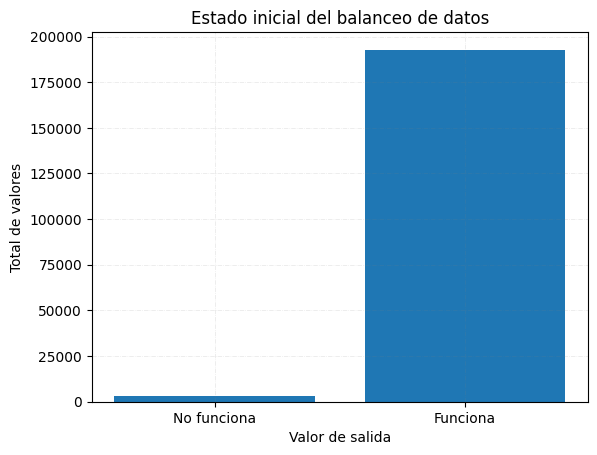

In [ ]:
# ------------------------------------------------------------------------------
# Comprobar el estado de balanceo de datos inicial
# ------------------------------------------------------------------------------
# Separammos los datos y definimos X e Y
X = dataCurrent.iloc[:, 0:dataCurrent.shape[1]-1]
Y = dataCurrent.iloc[:,   dataCurrent.shape[1]-1]

# Contamos las Y
salida_data = { 'No funciona':0 ,
                'Funciona':0}

salida_data['Funciona']    = sum(Y == 1)
salida_data['No funciona'] = sum(Y == 0)


# Hacer el barplot
# ---- Seleccionar datos
balanceoPlot = plt.bar(salida_data.keys(), salida_data.values())
# ---- Añadir las líneas horizontales
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# ---- Rótulos
plt.xlabel("Valor de salida")
plt.ylabel("Total de valores")
plt.title("Estado inicial del balanceo de datos")
plt.show()

Hasta aquí hemos comprobado que el balanceo de datos es incorrecto, y tenesmos unos 200.000 valores igual 1 frente a unos 3000 valores igual a 0.

Ahora procedemos a alegir de forma aleatoria que datos nos quedamos.

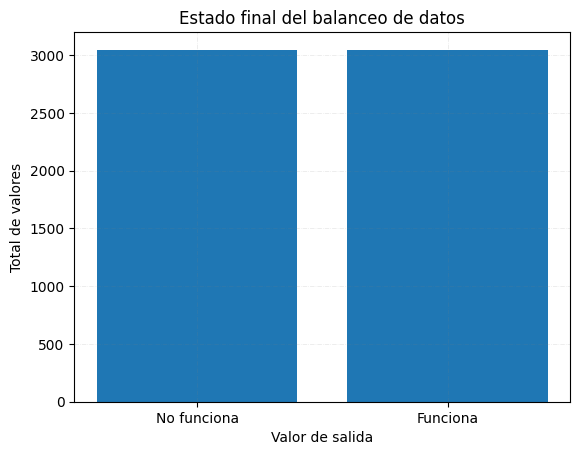

In [ ]:
# ------------------------------------------------------------------------------
# Elegimos las Y=1 de forma aleatoria
# ------------------------------------------------------------------------------
# Comprobamos que filas tienen 0s y cuales tienen 1s
trueRows  = [i for i, x in enumerate(Y) if x == 1]
falseRows = [i for i, x in enumerate(Y) if x == 0]

# Elegimos las filas con 1s de forma aleatoria
finalRows = random.choices(trueRows, k = salida_data['No funciona'])

# Añadimos las filas que tienen 0s
finalRows = finalRows + falseRows
finalRows.sort()

# Actualizamos los datos con las filas seleccionadas
dataCurrent = dataCurrent.iloc[ finalRows  , ]

# ------------------------------------------------------------------------------
# Comprobar el estado de balanceo de datos final
# ------------------------------------------------------------------------------
# Separammos los datos y definimos X e Y
X = dataCurrent.iloc[:, 0:dataCurrent.shape[1]-1]
Y = dataCurrent.iloc[:,   dataCurrent.shape[1]-1]

# Contamos las Y
salida_data = { 'No funciona':0 ,
                'Funciona':0}

salida_data['Funciona']    = sum(Y == 1)
salida_data['No funciona'] = sum(Y == 0)


# Hacer el barplot
# ---- Seleccionar datos
balanceoPlot = plt.bar(salida_data.keys(), salida_data.values())
# ---- Añadir las líneas horizontales
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# ---- Rótulos
plt.xlabel("Valor de salida")
plt.ylabel("Total de valores")
plt.title("Estado final del balanceo de datos")
plt.show()

Guardamos los datos balanceados para poder comparar con otros métodos

In [ ]:
# Preparamos el nombre de los ficheros
VERSION_150_X   = 'Datos_balanceados_X_150.txt'
VERSION_500_X   = 'Datos_balanceados_X_500.txt'
VERSION_6000_X  = 'Datos_balanceados_X_6000.txt'
VERSION_150_Y   = 'Datos_balanceados_Y_150.txt'
VERSION_500_Y   = 'Datos_balanceados_Y_500.txt'
VERSION_6000_Y  = 'Datos_balanceados_Y_6000.txt'

BASE_FOLDER = PROJECT_FOLDER + 'Resultados/Balanceo de datos/'


# Versión con 150 datos
# El número 42 es la semilla aleatoria a usar
y_1_indices = Y[Y == 1].sample(n=150, random_state=42).index
y_0_indices = Y[Y == 0].sample(n=150, random_state=42).index
Y_150_1 = Y.loc[y_1_indices]
X_150_1 = X.loc[y_1_indices]
Y_150_0 = Y.loc[y_0_indices]
X_150_0 = X.loc[y_0_indices]
Y_150 = pd.concat([Y_150_1, Y_150_0])
X_150 = pd.concat([X_150_1, X_150_0])

# Versión con 500 datos
y_1_indices = Y[Y == 1].sample(n=500, random_state=42).index
y_0_indices = Y[Y == 0].sample(n=500, random_state=42).index
Y_500_1 = Y.loc[y_1_indices]
X_500_1 = X.loc[y_1_indices]
Y_500_0 = Y.loc[y_0_indices]
X_500_0 = X.loc[y_0_indices]
Y_500 = pd.concat([Y_500_1, Y_500_0])
X_500 = pd.concat([X_500_1, X_500_0])

# Versión completa con 6000 datos
# (No hay que tocar nada)


# Guardamos todo
np.savetxt(BASE_FOLDER + VERSION_150_X,  X_150)
np.savetxt(BASE_FOLDER + VERSION_500_X,  X_500)
np.savetxt(BASE_FOLDER + VERSION_6000_X, X)
np.savetxt(BASE_FOLDER + VERSION_150_Y,  Y_150)
np.savetxt(BASE_FOLDER + VERSION_500_Y,  Y_500)
np.savetxt(BASE_FOLDER + VERSION_6000_Y, Y)

In [ ]:
# Preparamos el nombre de los ficheros
VERSION_TEST_X   = 'Datos_balanceados_X_TEST.txt'
VERSION_TEST_Y   = 'Datos_balanceados_Y_TEST.txt'
BASE_FOLDER = PROJECT_FOLDER + 'Resultados/Balanceo de datos/'
np.savetxt(BASE_FOLDER + VERSION_TEST_X,  X)
np.savetxt(BASE_FOLDER + VERSION_TEST_Y,  Y)

In [ ]:
print(X)
print(type(X))
print(Y)
print(type(Y))

        sensor_00  sensor_01  sensor_02  sensor_03   sensor_04  sensor_05  \
143      2.453588  49.262150  52.994790  45.746525  622.685200   72.71420   
215      2.449653  48.394100  52.994790  45.225690  646.527700   71.33772   
216      2.449653  48.133680  52.994790  45.182290  641.435200   70.39645   
377      2.445718  47.786460  52.734370  45.095490  635.416600   72.67522   
396      2.459491  47.135410  52.690970  44.921875  629.745400   75.84556   
...           ...        ...        ...        ...         ...        ...   
219578   2.397512  51.605900  51.432290  44.661457  627.777771   80.25206   
219581   2.399479  51.519096  51.302080  44.661460  633.564819   80.03590   
219742   2.399479  49.739580  52.734370  45.225693  634.953735   62.30679   
219781   2.402431  49.739582  52.951390  45.182289  630.324100   62.75538   
220312   2.404398  47.612850  50.520832  43.142361  637.036987   65.54104   

        sensor_06  sensor_07  sensor_08  sensor_09  ...  sensor_41  sensor_

<a name="entrenamientodatos"></a>
## Dividir el conjunto de datos en entrenamiento y prueba

Dividimos los datos de forma aleatoria para el conjunto de entrenamiento y para el conjunto de prueba. La opción por defecto es dividirlo en 80/20, puedes cambiar esto en la sección ["Opciones generales"](#opcionesgenerales)

In [ ]:
# Divide los datos que te quedan en Entrenamiento y Evaluación
dataCurrentTrain = dataCurrent.sample(frac = TRAIN_PROPORTION)
dataCurrentTest  = dataCurrent.drop(dataCurrentTrain.index)

# Crea los diferentes X e Y
Xtrain = dataCurrentTrain.iloc[  :  , 0:dataCurrent.shape[1]-1 ]
Xtest  = dataCurrentTest.iloc[   :  , 0:dataCurrent.shape[1]-1 ]

Ytrain = dataCurrentTrain.iloc[  :  ,   dataCurrent.shape[1]-1 ]
Ytest  = dataCurrentTest.iloc[   :  ,   dataCurrent.shape[1]-1 ]

# Guardamos las dimensiones de la matrix de entrada X para luego
totalInputsRows    = Xtrain.shape[0]
totalInputsColumns = Xtrain.shape[1]

# Guardamos el nombre de las variables para luego
variablesNames = list(Xtrain.columns)

# Guardamos el significado de los sensores para luego.
sensorNames = ["SENSOR_00", "SENSOR_01", "SENSOR_02", "SENSOR_03", "SENSOR_04",
                "SENSOR_05",    "SENSOR_06", "SENSOR_07", "SENSOR_08", "SENSOR_09",
                "SENSOR_10", "SENSOR_11",    "SENSOR_12", "SENSOR_13", "SENSOR_14",
                "SENSOR_16", "SENSOR_17", "SENSOR_18",    "SENSOR_19", "SENSOR_20",
                "SENSOR_21", "SENSOR_22", "SENSOR_23", "SENSOR_24",    "SENSOR_25",
                "SENSOR_26", "SENSOR_27", "SENSOR_28", "SENSOR_29", "SENSOR_30",
                "SENSOR_31", "SENSOR_32", "SENSOR_33", "SENSOR_34", "SENSOR_35",
                "SENSOR_36",    "SENSOR_37", "SENSOR_38", "SENSOR_39", "SENSOR_40",
                "SENSOR_41", "SENSOR_42",    "SENSOR_43", "SENSOR_44", "SENSOR_45",
                "SENSOR_46", "SENSOR_47", "SENSOR_48",    "SENSOR_49", "SENSOR_50",
                "SENSOR_51"]

sensorProperties = ["Motor Casing Vibration", "Motor Frequency A", "Motor Frequency B", "Motor Frequency C", "Motor Speed",
                     "Motor Current", "Motor Active Power", "Motor Apparent Power", "Motor Reactive Power", "Motor Shaft Power",
                     "Motor Phase Current A", "Motor Phase Current B", "Motor Phase Current C", "Motor Coupling Vibration", "Motor Phase Voltage AB",
                     "Motor Phase Voltage BC", "Motor Phase Voltage CA", "Pump Casing Vibration", "Pump Stage 1 Impeller Speed", "Pump Stage 1 Impeller Speed",
                     "Pump Stage 1 Impeller Speed", "Pump Stage 1 Impeller Speed", "Pump Stage 1 Impeller Speed", "Pump Stage 1 Impeller Speed", "Pump Stage 2 Impeller Speed",
                     "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed",
                     "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed", "Pump Stage 2 Impeller Speed", "Pump Inlet Flow", "Pump Discharge Flow",
                     "Pump UNKNOWN",    "Pump Lube Oil Overhead Reservoir Level", "Pump Lube Oil Return Temp", "Pump Lube Oil Supply Temp", "Pump Thrust Bearing Active Temp",
                     "Motor Non Drive End Radial Bearing Temp 1", "Motor Non Drive End Radial Bearing Temp 2", "Pump Thrust Bearing Inactive Temp",  "Pump Drive End Radial Bearing Temp 1", "Pump non Drive End Radial Bearing Temp 1",
                     "Pump Non Drive End Radial Bearing Temp 2", "Pump Drive End Radial Bearing Temp 2", "Pump Inlet Pressure", "Pump Temp Unknown", "Pump Discharge Pressure 1",
                     "Pump Discharge Pressure 2"]

# Recordamos que eliminamos los datos de los sensores 15 y 50. Así que
# procedemos a eliminar también los nombres de estas listas
#
# Pero el sensor 15, NO ESTÁ EN LA LISTA.
# Sólo quitamos el 50, que corresponde con la posición 49 (vaya lío)
del sensorProperties[49]
del sensorNames[49]





In [ ]:
# Preparamos el nombre de los ficheros
VERSION_TRAIN_X   = 'Datos_train_X_TEST.txt'
VERSION_TEST_X   = 'Datos_test_X_TEST.txt'
VERSION_TRAIN_Y   = 'Datos_train_Y_TEST.txt'
VERSION_TEST_Y   = 'Datos_test_Y_TEST.txt'
BASE_FOLDER = PROJECT_FOLDER + 'Resultados/Balanceo de datos/'
np.savetxt(BASE_FOLDER + VERSION_TRAIN_X, Xtrain )
np.savetxt(BASE_FOLDER + VERSION_TEST_X,  Xtest)
np.savetxt(BASE_FOLDER + VERSION_TRAIN_Y, Ytrain )
np.savetxt(BASE_FOLDER + VERSION_TEST_Y,  Ytest)

## Preparar los dataframes para el gráfico final

Al final de este documento, aparece una tabla de comparación con todos los métodos y todos los sensores. En estas variables vamos a ir guardando todos los datos para poder hacer la tabla final.

In [1]:
# Creamos el dataframe vacío donde guardamos las predicciones de cada modelo.
#
# El orden será
# ---- ANN
# ---- KNN
# ---- Random Forest (SHAP)
# ---- Random Forest (MDI)
# ---- PLS
# ---- AF-RL
shapAverageData    = pd.DataFrame(0, index=range(totalInputsColumns), columns=range(6))
shapSigmaData      = pd.DataFrame(0, index=range(totalInputsColumns), columns=range(6))
shapAbsAverageData = pd.DataFrame(0, index=range(totalInputsColumns), columns=range(6))
shapAbsSigmaData   = pd.DataFrame(0, index=range(totalInputsColumns), columns=range(6))


shapAverageData    = shapAverageData.set_axis(['ANN_SHAP', 'KNN_SHAP', 'RandomForest_SHAP', 'RandomForest_MDI', 'PLS', 'AF-RL'], axis=1)
shapSigmaData      = shapSigmaData.set_axis(['ANN_SHAP', 'KNN_SHAP', 'RandomForest_SHAP', 'RandomForest_MDI', 'PLS', 'AF-RL'], axis=1)
shapAbsAverageData = shapAbsAverageData.set_axis(['ANN_SHAP', 'KNN_SHAP', 'RandomForest_SHAP', 'RandomForest_MDI', 'PLS', 'AF-RL'], axis=1)
shapAbsSigmaData   = shapAbsSigmaData.set_axis(['ANN_SHAP', 'KNN_SHAP', 'RandomForest_SHAP', 'RandomForest_MDI', 'PLS', 'AF-RL'], axis=1)


NameError: name 'pd' is not defined

Añadimos los datos del modelo AF-RL que ya están calculados de antemano

In [ ]:
# -- Hay que usar sensor.csv de 120MB
AFRL_FILE      = "datos/importancia_componentes.txt"

# Cárgamos el archivo en un dataframe
# Los sensores 15 y 50 ya están eliminados
pesosAFRL = pd.read_csv( PROJECT_FOLDER + AFRL_FILE, sep = " ", header=None, index_col=False)
pesosAFRL[1] = pesosAFRL[1].astype(float)

# Hay que transformar los números en valor absoluto y normalizarlo entre 0 y 1
pesosAFRL[1] = np.abs(pesosAFRL[1])
pesosAFRL[1] = pesosAFRL[1] / max(pesosAFRL[1])


# Creamos un vector donde almacenamos los valores de importancia
vectorMedias    = np.zeros(50)
vectorAbsMedias = pesosAFRL[1]
vectorSigmas    = np.zeros(50)
vectorAbsSigmas = np.zeros(50)

# Lo metemos todo en la tabla final
shapAverageData.iloc[:,5]    = vectorMedias
shapSigmaData.iloc[:,5]      = vectorSigmas
shapAbsAverageData.iloc[:,5] = vectorAbsMedias
shapAbsSigmaData.iloc[:,5]   = vectorAbsSigmas


In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


In [ ]:
 print(shapAbsAverageData)

    ANN_SHAP  KNN_SHAP  RandomForest_SHAP  RandomForest_MDI  PLS     AF-RL
0          0         0                  0                 0    0  0.851552
1          0         0                  0                 0    0  0.658307
2          0         0                  0                 0    0  0.979559
3          0         0                  0                 0    0  1.000000
4          0         0                  0                 0    0  0.742020
5          0         0                  0                 0    0  0.094693
6          0         0                  0                 0    0  0.728024
7          0         0                  0                 0    0  0.406360
8          0         0                  0                 0    0  0.326612
9          0         0                  0                 0    0  0.450015
10         0         0                  0                 0    0  0.792770
11         0         0                  0                 0    0  0.943721
12         0         0   

[(*volver al índice*)](#indice)

# Modelos de predicción con redes neuronales

## Definición de modelos

En este caso tenemos que ir cambiando variables hasta que el modelo salga mejor. Por defecto usamos los siguientes parámetros que iremos refinando en los siguientes pasos:

*   **Red sequencial densa.** Esto significa que cada neurón de cada capa está conectado a todos los neurones de la capa siguiente.

*   **Activación ReLu** para capas intermedias. En el modelo recursivo no usaremos [ReLu](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/)).

*   **Activación sigmoide** para la capa final de salida.

*   El **algoritmo de optimización** para el modelo es **ADAM**, que es una combinación de Adaptive Gradient Algorithm (AdaGrad) con Root Mean Square Propagation (RMSProp). Este algoritmo es el mejor algoritmo básico y se adapta muy bien a toda clase de problemas.

*   **Función de pérdida mediante entropía cruzada binaria.** El modelo necesita un estimador para la [función de pérdida](https://es.wikipedia.org/wiki/Funci%C3%B3n_de_p%C3%A9rdida) para cada paso del algoritmo de optimización. Por defecto se suele usar el MSE (Error medio de cuadrados) para la función de regresión, pero en este caso en particular el modelo es un clasificador binario y sale mejor con [entropía binaria cruzada](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)

Vamos a probar con 3 modelos diferentes para comparar. Cada red neuronal tiene 50 entradas (columnas de X) y una salida (Y):


*   **Modelo A:** Una red de 2 capas intermedias de 10 neurones cada una.

![](https://drive.google.com/uc?export=view&id=1Jy-DZ_xNBioksdLRll6c3VSmB18I1-_1)


*   **Modelo B:** Una red sin capas intermedias.

*   **Modelo C:** Una red de 1 capa intermedia con 4 neurones.

In [ ]:
# Definir cuantas entradas tiene el modelo
myInputShape     = (totalInputsColumns,)

# Para los modelos lineales
# Vamos a usar 3 modelos y comparar la función LOSS de cada uno.
#
# -- Módelo A, una red con dos capas intermedias 10 x 10
# -- Módelo B, una red sin capas intermedias, sólamente 10 entradas y 1 salida.
# -- Módelo C, una red con una única capa intermedia de 4 neurones

# -----------
# MODELO A
# -----------
# Para el modelo A, definimos las siguientes capas ocultas:
modeloA_ocultaA = tf.keras.layers.Dense(units = 10, input_shape = myInputShape, activation = 'relu')
modeloA_ocultaB = tf.keras.layers.Dense(units = 10, activation = 'relu')
modeloA_salida  = tf.keras.layers.Dense(units = 1,  activation = 'sigmoid')

# -----------
# MODELO B
# -----------
# Para el modelo B, definimos la capa simple sin nada intermedio
modeloB_simple = tf.keras.layers.Dense(units = 1, input_shape = myInputShape, activation = 'sigmoid')

# -----------
# MODELO C
# -----------
# Para el modelo C, definimos la única capa intermedia
modeloC_ocultaA = tf.keras.layers.Dense(units = 4, input_shape = myInputShape, activation = 'relu')
modeloC_salida  = tf.keras.layers.Dense(units = 1, activation = 'sigmoid')



# Creamos cada uno de los modelos
modeloA = tf.keras.Sequential([modeloA_ocultaA, modeloA_ocultaB, modeloA_salida])
modeloB = tf.keras.Sequential([modeloB_simple])
modeloC = tf.keras.Sequential([modeloC_ocultaA, modeloC_salida])

# Compilamos cada uno de los modelos
modeloA.compile( optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy' )
modeloB.compile( optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy' )
modeloC.compile( optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy' )



<a name="entrenamientomodelos"></a>
## Entrenamiento del modelo.

En esta sección entrenamos el modelo. Esta es la parte que es computacionalmente más pesada, pero al ser este un modelo bastante simple con una matriz relativamente pequeña, no tarda mucho. Hay que darle 2 parámetros:

*   **Épocas.** Esto es cuanta paciencia tienes para entrenar el modelo. Es el número de pasos que va seguir hasta que converja (o no) a un LOSS que sea aceptable. A partir de la época 100 los modelos no cambian apenas. Le pongo 200 para asegurarme.

*   **Tamaño del lote** Cada una de las filas de la matriz X es una muestra. Aquí se define cuantas muestras se usan en cada paso del algoritmo. Puedes usar las [siguientes configuraciones](https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/):

    - **Stochastic Gradient Descent.** <font color='red'> Tamaño = 1. </font>   Fácil de entender, pero suele ser inestable y dar demasiados saltos sin que encuentre convergencia.

    - **Mini-batch Gradient Descent.** <font color='red'> Tamaño > 1 pero menor que el conjunto de muestras. </font> Un poco más eficiente computacionalmente, pero tienes que modificar el modelo y especificar lo que quieras. Valores pequeños convergen más rápido pero dan más ruido. Valores más altos convergen más lento pero son más precisos. El valor ideal es lo más alto posible siempre y cuando tu CPU sea capaz de procesar todos esos datos en paralelo. Un valor por defecto sensible suele ser 32. Yo le pongo 64 porque parecer ser lo que aguanta la CPU de Google.

    - **Batch Gradient Descent.** <font color='red'> Todas las muestras a la vez. </font>  Más eficiente computacionalmente y tardará menos en entrenar el modelo, pero suele encontrar convergencia demasiado rápido quedarse atrapado en mínimos locales.


Con los valores elegidos por defecto, esta parte tarda aproximadamente 1m 50s en ejecutarse

In [ ]:
print(Xtrain)
print(type(Xtrain))
print(Ytrain)
print(type(Ytrain))

        sensor_00  sensor_01  sensor_02  sensor_03   sensor_04  sensor_05  \
166296   2.492940  45.399303  52.256943  44.878471  613.657349   74.44014   
78292    0.001968  46.310760  47.135410  43.229160  179.192703    0.00000   
176471   2.449653  48.654510  50.954860  45.746525  640.740723   74.74729   
198677   2.466377  48.177082  52.560760  45.138885  617.013916   68.65705   
135639   0.001968  36.762150  34.461803  38.194443  204.146393    0.00000   
...           ...        ...        ...        ...         ...        ...   
89757    2.415220  48.828130  52.951390  43.663193  632.870400   64.35417   
34251    2.455556  48.654510  54.470490  45.138890  627.777800   83.36835   
135222   0.001968  36.241318  34.027775  38.368053  204.030655    0.00000   
114957   2.498843  48.437500  50.347221  41.276039  633.449100   82.48569   
20328    2.163368  49.088540  49.782990  46.484375  620.601800   95.12395   

        sensor_06  sensor_07  sensor_08  sensor_09  ...  sensor_41  sensor_

Comenzando a entrenar...
    Modelo A...
    Modelo B...
    Modelo C...
Entrenamiento concluido


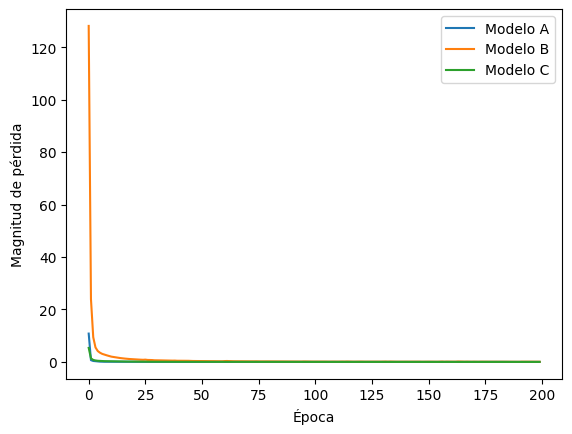

In [ ]:
# Entrenamos el modelo
# - Las epocas es cuantas vueltas da el modelo
# - El lote es cuantas muestras de Y usamos para entrenar el modelo cada vez
EPOCAS = 200
LOTE   = 64
print("Comenzando a entrenar...")

# Modelo A
print("    Modelo A...")
historialA = modeloA.fit(Xtrain, Ytrain, epochs = EPOCAS, batch_size = LOTE, verbose = False)

# Pintamos la función LOSS con respecto a las épocas
plt.xlabel("Época")
plt.ylabel("Magnitud de pérdida")
plt.plot(historialA.history["loss"], label='Modelo A')

# Modelo B
print("    Modelo B...")
historialB = modeloB.fit(Xtrain, Ytrain, epochs = EPOCAS, batch_size = LOTE, verbose = False)
plt.plot(historialB.history["loss"], label='Modelo B')

# Modelo C
print("    Modelo C...")
historialC = modeloC.fit(Xtrain, Ytrain, epochs = EPOCAS, batch_size = LOTE, verbose = False)
plt.plot(historialC.history["loss"], label='Modelo C')

# Cuando termine el entrenamiento comunicamos que está terminado
print("Entrenamiento concluido")

# Pintamos la leyenda para cada modelo y mostramos el gráfico
leg = plt.legend()
plt.show()

<a name="evaluacionmodelos"></a>
## Evaluación del modelo

Del gráfico anterior, podemos ver que la función de pérdida es peor en el modelo B que es el más simple. Pero todos convergen a un error próximo a cero al poco tiempo. Ahora tenemos que evaluar el modelo.

Vamos a ver la precisión y curva ROC para cada uno de los modelos. En esta parte usamos sólamente el conjunto de prueba.

Modelo A: 
0.012097624130547047
0.9969224333763123

Modelo B: 
0.06876028329133987
0.9934345483779907

Modelo C: 
0.012175505980849266
0.995896577835083



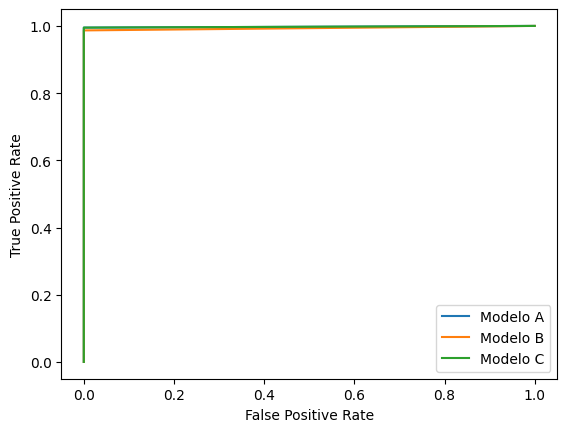

In [ ]:
# Evaluamos el modelo y mostramos LOSS y precisión
print("Modelo A: ")
print(historialA.history["loss"][EPOCAS-1])
print(historialA.history['accuracy'][EPOCAS-1])
print()
print("Modelo B: ")
print(historialB.history["loss"][EPOCAS-1])
print(historialB.history['accuracy'][EPOCAS-1])
print()
print("Modelo C: ")
print(historialC.history["loss"][EPOCAS-1])
print(historialC.history['accuracy'][EPOCAS-1])
print()


# Evaluamos el modelo mostrando las curvas ROC para cada uno
modeloA_prediccion = (modeloA.predict(Xtest,    verbose = False) > 0.5).astype(int)
modeloB_prediccion = (modeloB.predict(Xtest,    verbose = False) > 0.5).astype(int)
modeloC_prediccion = (modeloC.predict(Xtest,    verbose = False) > 0.5).astype(int)

fprA , tprA , thresholdsA = roc_curve(Ytest    , modeloA_prediccion)
fprB , tprB , thresholdsB = roc_curve(Ytest    , modeloB_prediccion)
fprC , tprC , thresholdsD = roc_curve(Ytest    , modeloC_prediccion)

# Pintamos el gráfico
plt.plot(fprA, tprA, label = 'Modelo A')
plt.plot(fprB, tprB, label = 'Modelo B')
plt.plot(fprC, tprC, label = 'Modelo C')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

leg = plt.legend()

plt.show()



<a name="importanciavariables"></a>
## Importancia de cada variable.

SHapley Additive exPlanations (SHAP) calcula los valores de Shapley, que es un concepto de la Teoría de Juegos Cooperativos, para explicar la contribución de cada uno de los característica de entrada a la predicción final del modelo. SHAP se puede utilizar en cualquier algoritmo de aprendizaje y es fácil de interpretar, pero requiere un gran número de muestras para capturar adecuadamente las interacciones de las variables lo que es computacionalmente costoso.

Como regla general, los modelos que son difíciles de interpretar, como las redes neuronales, son mejores prediciendo resultados. Y los modelos que son más fáciles de interpretar, como los random forests, tienden más al sobreajuste o son peores prediciendo el resultado final.

In [ ]:
# Transforma los datos de dataframe a matriz para poder usarlos en las
# siguientes funciones
XtrainNumpy = Xtrain.to_numpy()
YtrainNumpy = Ytrain.to_numpy()
XtestNumpy  = Xtest.to_numpy()
YtestNumpy  = Ytest.to_numpy()

# Usar este algorithmo con muchas muestras tarda mucho tiempo
# Aquí pruebo a reducirlo un poco para probar los resultados iniciales

# ---- Primero, decir cuantas veces se van a ejecutar el test. En este caso 200.
mySamples   = shap.sample(XtestNumpy, TOTAL_SHAP_TESTS)

# ---- Se hacen las predicciones.
explainer    = shap.KernelExplainer(modeloA.predict,mySamples)
shap_values2 = explainer(mySamples)


1/1 [==============================] - 0s 55ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

672/672 [==============================] - 3s 4ms/step


Guardamos los resultados del SHAP para ANNs en nuestro dataframe grande para al final hacer el mapa de calor.

In [ ]:
# Creamos un vector donde almacenamos los valores SHAP para cada uno de los sensores
#vectorMedias    = np.mean(shap_values[0], axis=0)
#vectorAbsMedias = np.mean(np.absolute(shap_values[0]), axis=0)
#vectorSigmas    = np.std(shap_values[0], axis=0)
#vectorAbsSigmas = np.std(np.absolute(shap_values[0]), axis=0)


# Creamos un vector donde almacenamos los valores SHAP para cada uno de los sensores
vectorMedias    = np.mean(shap_values2.values, axis=0)
vectorAbsMedias = np.mean(np.absolute(shap_values2.values), axis=0)
vectorSigmas    = np.std(shap_values2.values, axis=0)
vectorAbsSigmas = np.std(np.absolute(shap_values2.values), axis=0)


# Y también lo guardamos para nuestra trabla final.
shapAverageData.iloc[:,0]    = vectorMedias
shapSigmaData.iloc[:,0]      = vectorSigmas
shapAbsAverageData.iloc[:,0] = vectorAbsMedias
shapAbsSigmaData.iloc[:,0]   = vectorAbsSigmas



```
# This is formatted as code
```

Hay varias formas de visualizar los valores SHAP. Por ejemplo, podemos hacer un gráfico de barras con los valores absolutos medios de cada variable y ver cuales tienen más impacto en el modelo.

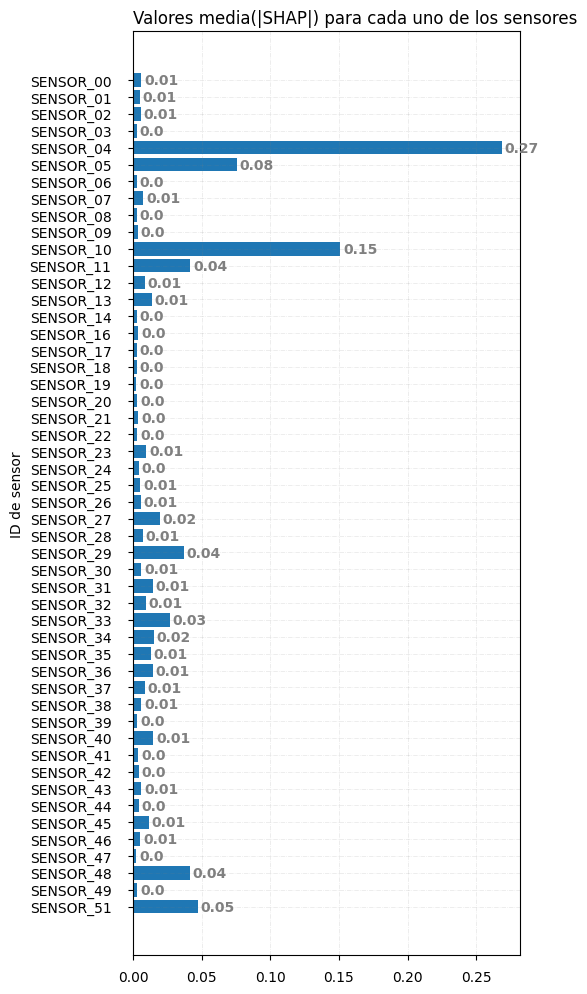

In [ ]:
# Mostrar el gráfico

# Este comando es lo mismo, pero sólo muestra los 20 primeros, para mantener consistencia muestro los 50 sensores.
# shap.summary_plot( shap_values , mySamples, feature_names = list(Xtrain.columns) )

variablesNames = list(Xtrain.columns)
currentPlotTitle = 'Valores media(|SHAP|) para cada uno de los sensores'

# Create the plot dataframe

#barplotData = np.zeros((200, 50))
barplotData = pd.DataFrame( np.zeros([len(sensorNames),2]) , columns = ['name', 'value'] )
barplotData.iloc[:,0] = sensorNames
barplotData.iloc[:,1] = vectorAbsMedias

# Figure Size
fig, ax = plt.subplots(figsize=(5, 12))

# Horizontal Bar Plot
plt.barh(barplotData.iloc[:,0],  barplotData.iloc[:,1])

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=7)
ax.yaxis.set_tick_params(pad=12)

ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Show first values on top
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:

  currentOffset = 0.002
  currentW = i.get_width()
  if(currentW < 0): currentOffset = -0.005

  plt.text(i.get_width() + currentOffset, i.get_y() + 0.65,
           str(round((i.get_width()), 2)),
           fontsize=10, fontweight='bold',
           color='grey')


# Add Plot Title
ax.set_title(currentPlotTitle,loc='left', )
ax.set_ylabel("ID de sensor")

# Show Plot
plt.show()

SHAP incluye otros métodos de visualización que son un poco más complejos. Por ejemplo el beeswarm:

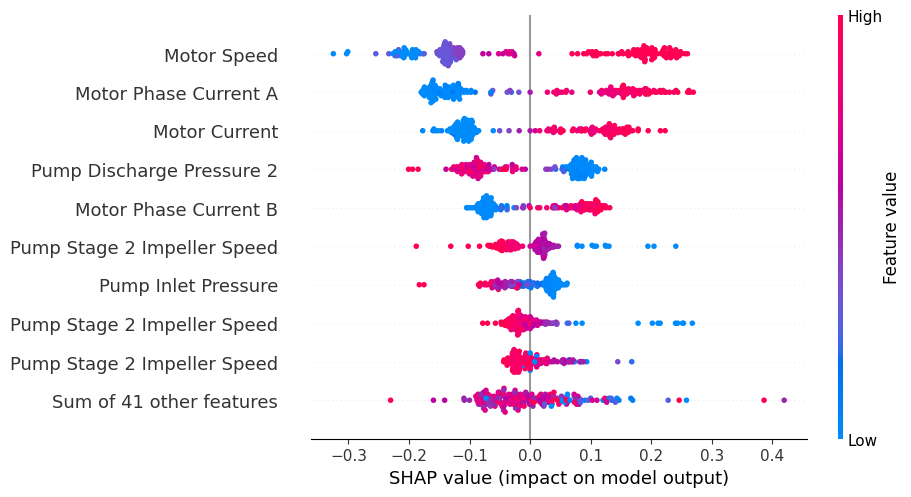

In [ ]:
# Para poder hacer el beeswarm hay que hacer unas transformaciones un poco raras
# primero. Aquí simplemente convierto un objecto explanation del SHAP a otro
# objeto.
shap_values3 = shap_values2
shap_values3.values = np.squeeze(shap_values2.values)

explanation3 = shap.Explanation(
    values=shap_values3.values,
    base_values=shap_values3.base_values,
    data=shap_values3.data,
    feature_names=sensorProperties
)
shap.plots.beeswarm(explanation3)


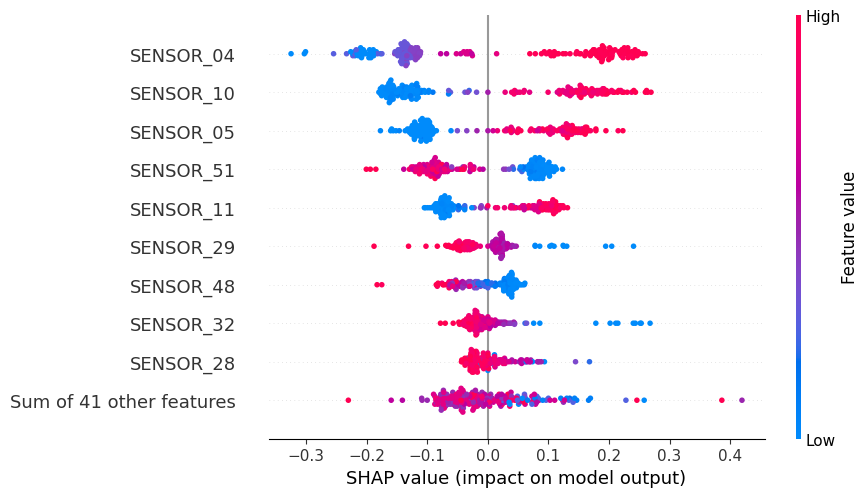

In [ ]:
# Mismo gráfico con ID de sensor en lugar de función
shap_values3 = shap_values2
shap_values3.values = np.squeeze(shap_values2.values)

explanation3 = shap.Explanation(
    values=shap_values3.values,
    base_values=shap_values3.base_values,
    data=shap_values3.data,
    feature_names=sensorNames
)
shap.plots.beeswarm(explanation3)

Se puede cambiar del tipo beeswarm a violin. El significado es el mismo y representa lo mismo. El tipo violin simplemente esconde los punto y trata de hacer una distribución más suave.

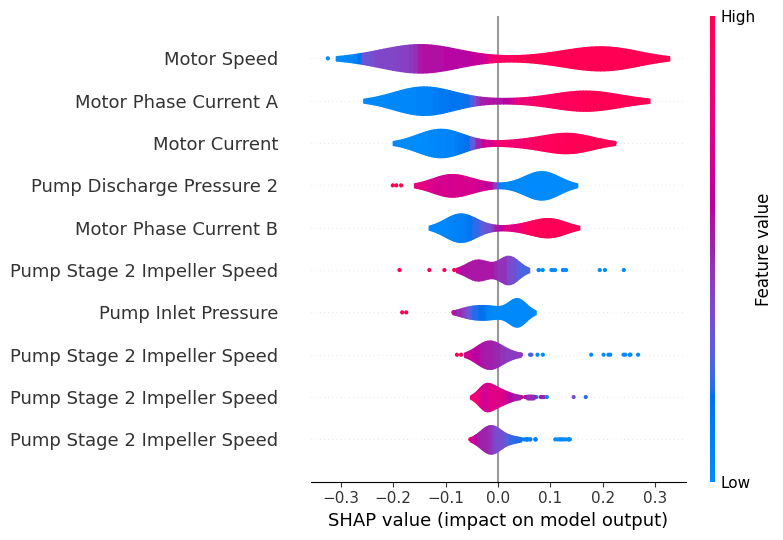

In [ ]:
shap.summary_plot(explanation3, plot_type='violin', max_display=10)

Guardamos los datos SHAP en un fichero. Cuando hacemos las simulaciones grandes puede tardar un par de horas. Así que podemos guardarlas y no tenemos que volver a calcularlas cada vez.

In [ ]:
ANN_EXPLANATION_VALUES      = 'explanationValues.txt'
ANN_EXPLANATION_BASE_VALUES = 'explanationBase.txt'
ANN_EXPLANATION_DATA        = 'explanationData.txt'
ANN_EXPLANATION_FEATURES    = 'explanationFeatures.txt'

BASE_FOLDER = PROJECT_FOLDER + 'Resultados/Datos completos de SHAP/ANN/'

np.savetxt(BASE_FOLDER + ANN_EXPLANATION_VALUES,      shap_values2.values)
np.savetxt(BASE_FOLDER + ANN_EXPLANATION_BASE_VALUES, shap_values2.base_values)
np.savetxt(BASE_FOLDER + ANN_EXPLANATION_DATA,        shap_values2.data)
np.savetxt(BASE_FOLDER + ANN_EXPLANATION_FEATURES,    sensorNames,              fmt='%s')


Hacemos los gráficos de dependencias de componentes. Estos gráficos explican si la variable tiende a FALLO o FUNCIONAR en función del valor de la variable. Los gráficos ya están hechos y guardados en la carpeta de resultados, así que no hace falta vovler a generarlos.

In [ ]:
# Hay que ponerle nombre a las esperanzas de cada variable.
# Es un poco lío porque no lo hace de forma automática, pero con esto
# se arregla.
XtestNumpy2 = pd.DataFrame(XtestNumpy, columns=sensorNames)

# Para cada sensor
for k in range( len(sensorProperties) ):

    # Elegimos el texto para el título y los ejes
    currentVariableName = sensorProperties[k]
    currentTitle = "Modelo A: " + currentVariableName
    #currentXaxis = sensorNames[k]
    #currentYaxis = "E(f(x) | " + currentXaxis + ")"

    # Hacemos el gráfico
    shap.partial_dependence_plot(k, modeloA.predict, XtestNumpy2,
                                 ice=False, model_expected_value=True,
                                 feature_expected_value=True, show=False)

    # Cambiamos el título y los ejes
    plt.title(currentTitle, y=1.1)

    # Mostramos el gráfico
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

[(*volver al índice*)](#indice)

<a name="pls"></a>
# Modelo con regresión parcial de componentes (PLS regression)

Uno de los problemas más comunes cuando defines un modelo del tipo que sea, ya sea mediante machine learning, o haciendo una recta de regresión simple, es definir las variables que vas a usar para adivinar el conjunto de variables que quieres predecir.

Puede ser que las variables que elijas presenten un problema de multicolinearidad, que signica que las variables están altamente correlacionadas y significan casi lo mismo. Tu modelo va a funcionar genial con los datos que tienes, pero va a hacer predicciones muy pobres en conjuntos de datos nuevos.

Una forma de solucionar esto es mediante reducción de dimensionalidad usando PCA. Pero a PCA no le importa que las predicciones salgan bien o mal, lo que hace es intentar maximizar la variabilidad entre las componentes y la variable de salida.

Para corregir eso, se usa PLS, que mezcla la variabilidad de PCA con la correlación entre las variables de entrada y salida.

En nuestro caso vamos a usar [PLS-DA](https://en.wikipedia.org/wiki/Partial_least_squares_regression) , que es un clasificador para variables discretas ya que nuestra Y puede ser 0 (la red no funciona) o 1 (la red funciona)

Aquí hay un vídeo [06:53] con una introducción sencilla a [PLS-DA](https://www.youtube.com/watch?v=zqFZ0mEc74k)

Y aquí hay un PDF con una introducción más detallada sobre la implementación de esta función, y en particular el algoritmo [NIPALS](http://users.cecs.anu.edu.au/~kee/pls.pdf) (Nonlinear Iterative Partial Least Squares)

In [ ]:
# Crea los diferentes X e Y
X = dataCurrent.iloc[  :  , 0:dataCurrent.shape[1]-1 ]
Y = dataCurrent.iloc[  :  ,   dataCurrent.shape[1]-1 ]

# Guardamos las dimensiones de la matrix de entrada X para luego
totalInputsRows    = X.shape[0]
totalInputsColumns = X.shape[1]

# Normalizamos las matrices X e Y. En nuestro caso ya están centradas y ninguna
# variable parace tener una escala diferente al resto que pueda afectar a la
# variabilidad, pero lo dejamos hecho por si acaso.
Xnorm = X - X.mean()
Xnorm = Xnorm / Xnorm.max()
Ynorm = Y - Y.mean()
Ynorm = Ynorm / Ynorm.max()

In [ ]:
# Definimos una función que va a probar la misma función de PLSR para diferentes
# cantitades de componenetes. PLSR nos va a devolver el error cuadrado medio (MSE)
# para número de componentes que le digamos. Eso lo guardamos en un vector, y
# nos quedamos con el número de componentes que hace MSE mínimo.

# Al igual que en PCA, estó va a presentar un scree-plot. Aunque el MSE sea
# mínimo para un número de componentes determinado, es posible que sea más
# interesante usar un número de componentes distinto al mínimo si no hay mucha
# diferencia con respecto al MSE para ese número de componentes.

def optimise_pls_cv(X, Y, n_comp, plot_components=True):

    # Guardamos cual es el MSE minimo y el mejor modelo posible.
    #
    # Inicializamos el mejor resultado a MSE = 9999 y número de componentes
    # mayor al número total de variables que tenemos. Este es un resultado
    # imposible y está programado así a drede.
    #
    # Así forzamos a que la primera opción mejore el mejor resultado de
    # inicialización y no hace falta hacer casos especiales dentro del bucle.
    mse_minimo        = 99999
    mejor_componentes = n_comp + 10
    mejor_modelo_pls  = NULL
    mejor_validacion  = NULL

    # Guardamos todos los MSE aquí.
    mse = []

    # Generamos un vector con cada una de las cantidades de componentes posibles
    component = np.arange(1, n_comp)

    # Para componente, hacemos PLSR y encontramos el MSE
    for i in component:

        # Hacemos PLS
        modelo_pls_actual = PLSRegression(n_components = i)

        # Hacemos validación cruzada para ver que tal se comporta el modelo
        #
        # ---- Calculamos los Ŷ
        #
        #      El número por defecto para hacer la validación cruzada es 5,
        #      yo aquí le he puesto 10 sin ningún motivo en especial.
        #
        y_cv = cross_val_predict(modelo_pls_actual, X, Y, cv = 10)

        # ---- Hayamos MSE
        mse_actual = mean_squared_error(Y, y_cv)
        mse.append(mse_actual)
        #
        # comp = 100 * ( i + 1) / n_comp

        # Actualizamos el mejor modelo posible si encontramos uno mejor
        if(mse_minimo > mse_actual):
            mse_minimo        = mse_actual
            mejor_componentes = i
            mejor_modelo_pls  = modelo_pls_actual
            mejor_validacion  = y_cv


    # Indicamos cual ha sido el mejor número de componentes
    print("Sugerimos usar este número de componentes: ", mejor_componentes)

    # Opcionalmente, podemos enseñar la gráfica con los valores de MSE
    if (plot_components):
        with plt.style.context(('ggplot')):
             plt.plot( component,         np.array(mse), '-v', color = 'blue', mfc = 'blue')
             plt.plot( mejor_componentes, mse_minimo,    'P', ms = 10, mfc = 'red')
             plt.xlabel('Número de componentes PLS')
             plt.ylabel('MSE')
             plt.title('PLS')
             plt.xlim(left=-1)

        plt.show()


    # Ajustamos los datos al mejor modelo encontrado
    mejor_modelo_pls.fit(X, Y)
    y_c = mejor_modelo_pls.predict(X)

    # Calculamos los valores de R2 para calibración y validación cruzada (cross-validation ; cv)
    score_c  = r2_score(Y, y_c)
    score_cv = r2_score(Y, mejor_validacion)

    # Calculamos el MSE para calibración y validación cruzada
    mse_c  = mean_squared_error(Y, y_c)
    mse_cv = mean_squared_error(Y, mejor_validacion)

    print('R2 calib:'  + str(score_c))
    print('R2 CV:'     + str(score_cv))
    print('MSE calib:' + str(mse_c))
    print('MSE CV:'    + str(mse_cv))

    # Plot regression and figures of merit
    rangey = max(Y) - min(Y)
    rangex = max(y_c) - min(y_c)

    # Fit a line to the CV vs response
    z = np.polyfit(Y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, Y, c='red', edgecolors='k')
        #Plot the best fit line
        ax.plot(np.polyval(z,Y), Y, c='blue', linewidth=1)
        #Plot the ideal 1:1 line
        ax.plot(Y, Y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted')
        plt.ylabel('Measured')

    plt.show()

    return mejor_componentes

In [ ]:
print(type(Xnorm))
print(type(Ynorm))
print(type(totalInputsColumns))
print("------------------------")
print(Xnorm)
print(Ynorm)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'int'>
------------------------
        sensor_00  sensor_01  sensor_02  sensor_03  sensor_04  sensor_05  \
143      0.926325   0.372528   0.691998   0.605685   0.834638   0.549864   
215      0.923287   0.296929   0.691998   0.512905   0.930594   0.527156   
216      0.923287   0.274249   0.691998   0.505174   0.910099   0.511627   
377      0.920249   0.244010   0.663566   0.489711   0.885877   0.549220   
396      0.930883   0.187310   0.658828   0.458784   0.863052   0.601522   
...           ...        ...        ...        ...        ...        ...   
219578   0.883032   0.576645   0.521412   0.412394   0.855134   0.674217   
219581   0.884551   0.569085   0.507196   0.412394   0.878424   0.670651   
219742   0.884551   0.414107   0.663566   0.512905   0.884014   0.378171   
219781   0.886830   0.414107   0.687260   0.505174   0.865381   0.385571   
220312   0.888348   0.228890   0.421904   0.141786 

Sugerimos usar este número de componentes:  24


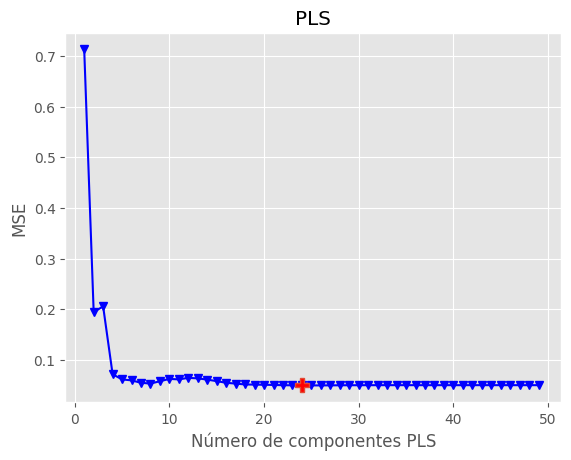

R2 calib:0.9769456699788207
R2 CV:0.9503165434373961
MSE calib:0.02305433002117928
MSE CV:0.04968345656260383


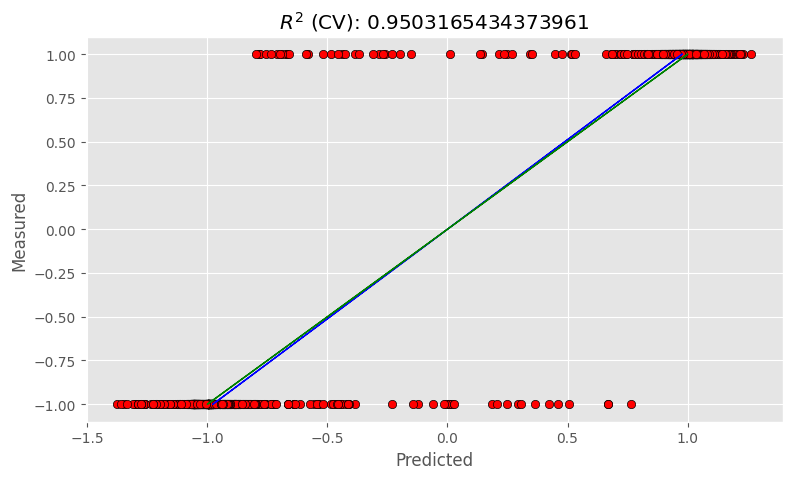

24

In [ ]:
optimise_pls_cv(Xnorm,Ynorm, totalInputsColumns , plot_components=True)

Elegimos el número de componentes que queramos en función al resultado anterior.

Parece que a partir de 5 no mejora mucho, así que vamos a probar con 5 a ver que pasa.

Aquí los resultados suelen dar entre 98.5% y 99.5%

El algoritmo de PLS es muy rápido para los tamaños de los conjuntos de entrenamiento y prueba que tenemos. Vamos a ejecutarlo 100 veces y ver cuál es la media y desviación típica de la fiabilidad. Esto va a tardar unos 6s en ejecutar las 100 iteraciones.

In [ ]:
print(X)
print(type(X))
print(Y)
print(type(Y))

        sensor_00  sensor_01  sensor_02  sensor_03   sensor_04  sensor_05  \
143      2.453588  49.262150  52.994790  45.746525  622.685200   72.71420   
215      2.449653  48.394100  52.994790  45.225690  646.527700   71.33772   
216      2.449653  48.133680  52.994790  45.182290  641.435200   70.39645   
377      2.445718  47.786460  52.734370  45.095490  635.416600   72.67522   
396      2.459491  47.135410  52.690970  44.921875  629.745400   75.84556   
...           ...        ...        ...        ...         ...        ...   
219578   2.397512  51.605900  51.432290  44.661457  627.777771   80.25206   
219581   2.399479  51.519096  51.302080  44.661460  633.564819   80.03590   
219742   2.399479  49.739580  52.734370  45.225693  634.953735   62.30679   
219781   2.402431  49.739582  52.951390  45.182289  630.324100   62.75538   
220312   2.404398  47.612850  50.520832  43.142361  637.036987   65.54104   

        sensor_06  sensor_07  sensor_08  sensor_09  ...  sensor_41  sensor_

In [ ]:
# Inicializamos una variable donde guardaremos los datos de pesos de los coeficientes
plsData = np.zeros((200, 50))

# Generamos un vector donde guardamos las fiabilidades
vectorFiabilidades = np.zeros(200)

# Copio los datos que tenemos en otros dataframes por si acaso se modifican
df_x = pd.DataFrame(X)
df_y = pd.DataFrame(Y)

# Para cada modelo, generamos una fiabilidad distinta
# Usamos 200 iteraciones para que coincida con las iteraciones del SHAP
for j in range(0,200):

  # Creamos el modelo PLS
  pls2 = PLSRegression(n_components = 5)

  # Dividimos los datos en conjunto de entrenamiento y test igual que antes
  x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size= (1 - TRAIN_PROPORTION)) # Atención que elige la proporción complementariar a la anterior para dividir en 80% entrenamiento 20% test

  # Ajustar el modelo
  pls2.fit(x_train, y_train)

  # Predecir valores
  Y_pred = pls2.predict(x_test)
  Y_addjusted = Y_pred.copy()

  # Los Ys se predicen por una función que dará un resultado continuo
  # Así que aquí se convierten los datos en lo que tenga más cerca cada uno
  # Convertir los Y_pred en 0s si es menor que 0.5, y al contrario para 1s
  for i in range(0,Y_pred.shape[0]):
    if(Y_addjusted[i] < 0.5): Y_addjusted[i] = 0
    else: Y_addjusted[i] = 1

  # Comparamos las predicciones con el conjunto del test
  predicciones = Y_addjusted == y_test
  fiabilidad   = sum(predicciones['new'])/Y_pred.shape[0]

  # Lo guardamos en el vector grande
  vectorFiabilidades[j] = fiabilidad

  # Igual que antes, guardamos los resultados para el vector de medias y sigmas
  plsData[j] = np.squeeze(pls2.coef_)


The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
The attribute `coef_` will be transposed in version 1.3 to be consistent with other linear models in scikit-learn. Currently, `coef_` has a shape of (n_features, n_targets) and in the future it will have a shape of (n_targets, n_features).
The attribute `coef_` will be transposed

In [ ]:
# Creamos un vector donde almacenamos los valores PLS para cada uno de los sensores
vectorMedias    = np.mean(plsData, axis=0)
vectorAbsMedias = np.mean(np.absolute(plsData), axis=0)
vectorSigmas    = np.std(plsData, axis=0)
vectorAbsSigmas = np.std(np.absolute(plsData), axis=0)


In [ ]:
# Nombre del fichero y directorio donde se guarda
PLS_WEIGHTS = 'PLS_Importancias.csv'
BASE_FOLDER = PROJECT_FOLDER + 'Resultados/PLS/'

# Se convierten los resultados a un dataframe
PLS_WEIGHTS_DF = pd.DataFrame({'Means':    np.squeeze(vectorMedias),
                               'AbsMeans': np.squeeze(vectorAbsMedias),
                               'Sigma':    np.squeeze(vectorSigmas),
                               'AbsSigma': np.squeeze(vectorAbsSigmas)})


# Guardar el resultado para que luego se pueda hacer el heatmap
PLS_WEIGHTS_DF.to_csv( BASE_FOLDER + PLS_WEIGHTS, index=False)

In [ ]:
# Comprobamos que las predicciones del PLS son fiables
print(np.mean(vectorFiabilidades))
print(np.std(vectorFiabilidades))



0.9912264150943396
0.0024530873902480197


Vamos a ver cuales son las componentes más importantes según este modelo

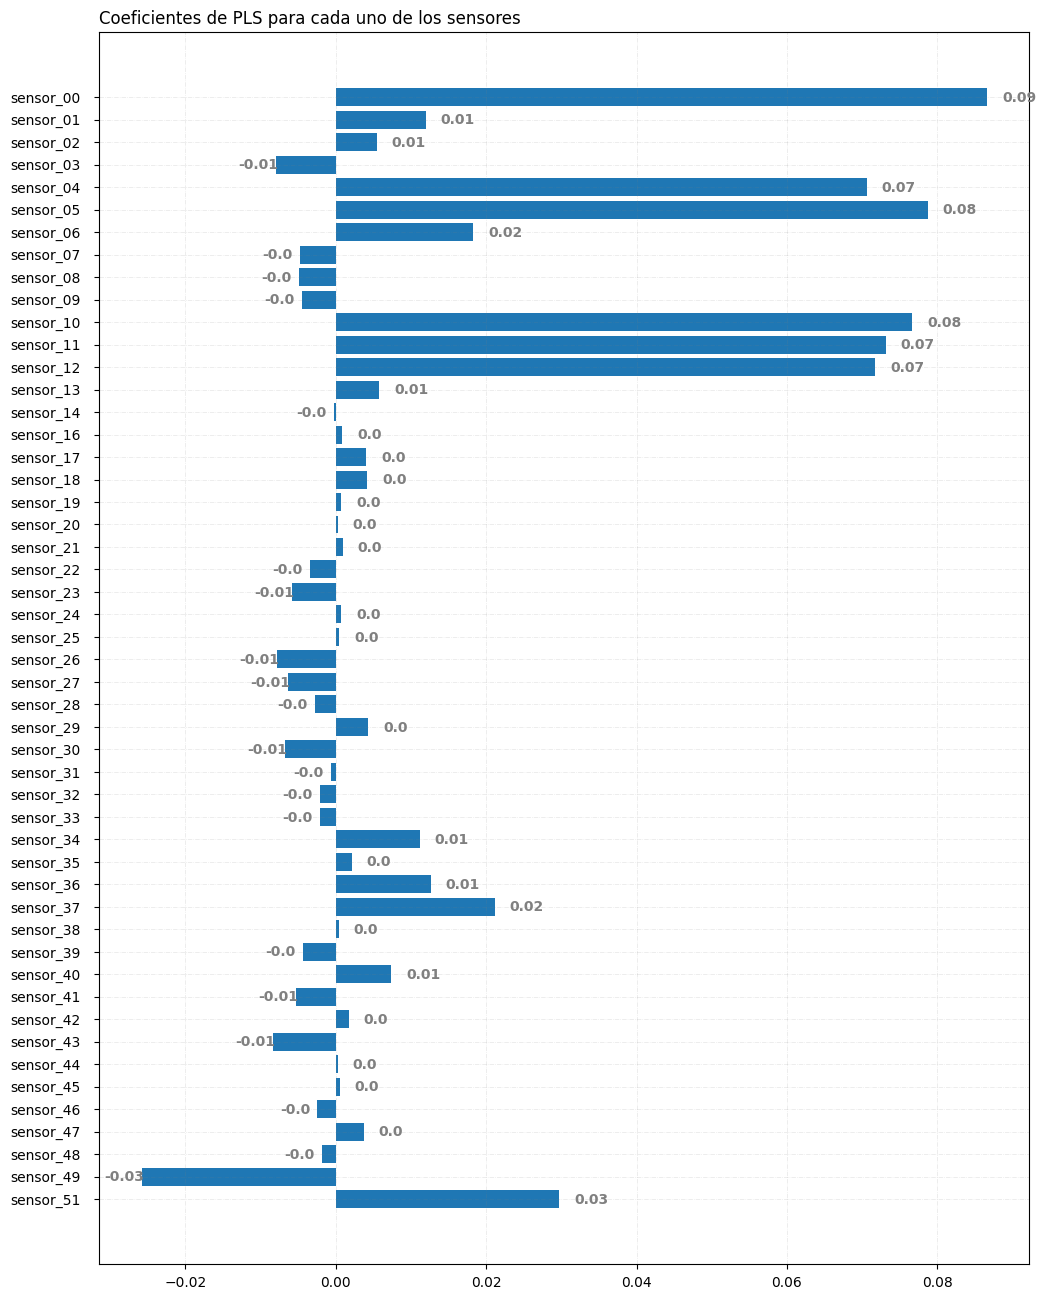

In [ ]:
# Usamos el último modelo generado para este gráfico. En la tabla final vermos
# las medias de todos los valores de todos los sensores de todos los métodos.
barplotData = pd.DataFrame( np.zeros([len(pls2.coef_),2]) )
barplotData[0] = X.columns
barplotData[1] = pls2.coef_

# Figure Size
fig, ax = plt.subplots(figsize=(12, 16))

# Horizontal Bar Plot
plt.barh(barplotData[0], barplotData[1])

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# ---- Rótulos

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:

    currentOffset = 0.002
    currentW = i.get_width()
    if(currentW < 0): currentOffset = -0.005

    plt.text(i.get_width() + currentOffset, i.get_y() + 0.6,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Coeficientes de PLS para cada uno de los sensores',
             loc='left', )

# Show Plot
plt.show()

A partir de aquí no hay nada más interesante, es solamente una muestra de código para ver como se saca la matriz de pesos, variabilidad, normalización, etc...

In [ ]:
# Hacemos las variables
total_variance_in_x  = np.var(x_test, axis = 0)
variance_in_x        = np.var(pls2.x_scores_, axis = 0)
pesosPLSNormalizados = pls2.x_scores_ - np.dot(    scale(x_train)    ,    pls2.x_weights_    ) / pls2.x_scores_
pesosPLS             = pls2.x_scores_

# Preparamos el nombre de los ficheros
PLS_VARIANZA_TOTAL_X   = 'PLS_varianzaTotalX.txt'
PLS_VARIANZA_X         = 'PLS_varianzaX.txt'
PLS_PESOS_NORMALIZADOS = 'PLS_pesosNormalizados.txt'
PLS_PESOS              = 'PLS_pesos.txt'

BASE_FOLDER = PROJECT_FOLDER + 'Resultados/PLS/'

# Guardamos todo
np.savetxt(BASE_FOLDER + PLS_VARIANZA_TOTAL_X,      total_variance_in_x)
np.savetxt(BASE_FOLDER + PLS_VARIANZA_X, variance_in_x)
np.savetxt(BASE_FOLDER + PLS_PESOS_NORMALIZADOS,        pesosPLSNormalizados)
np.savetxt(BASE_FOLDER + PLS_PESOS,    pesosPLS)

In [ ]:

print(total_variance_in_x)
print(variance_in_x)
print(pesosPLSNormalizados)
print(pesosPLS)


sensor_00        1.436597
sensor_01       23.108836
sensor_02       49.871380
sensor_03        9.025839
sensor_04    53016.658896
sensor_05     1412.980777
sensor_06       30.692135
sensor_07       40.088291
sensor_08       38.008536
sensor_09       37.824982
sensor_10      482.997163
sensor_11      517.378117
sensor_12      260.546697
sensor_13       39.286135
sensor_14     7524.924461
sensor_16     9203.847577
sensor_17     9769.212428
sensor_18        0.323828
sensor_19    22626.684936
sensor_20     5920.808866
sensor_21    29284.134939
sensor_22    14081.571741
sensor_23    49703.466131
sensor_24    18649.245438
sensor_25    28748.935581
sensor_26    36242.839890
sensor_27    12162.424750
sensor_28    72461.588127
sensor_29    32430.505020
sensor_30    21932.730259
sensor_31    48022.784526
sensor_32    38901.889943
sensor_33    12769.031877
sensor_34     5404.079394
sensor_35    14767.996264
sensor_36    70193.900657
sensor_37     1026.894806
sensor_38     1160.258080
sensor_39   

Ordenamos los pesos en forma de tabla

[(*volver al índice*)](#indice)

<a name="knn"></a>
# KNN (K-Nearest Neighbors)

El algoritmo de kNN es un clasificador que funciona tanto para variables discretas como variables continuas.

Vídeo de introducción https://www.youtube.com/watch?v=48RqX4HTtCE

La ventaja sobre las redes neuronales es que, en comparación, el entrenamiento del modelo es casi inmediato. En contraposición, no sirve para modelos mucho más complejos como pudiera ser redes convulucionales para generación de imágenes o modelos de lenguaje, entre otros. También es difícil poder estimar la importancia de cada variable en el modelo; para ello es mejor usar un Random Forest or regresión Lasso.

No confundir kNN con el algoritmo K-means, que se usa para el clustering de datos.

Aquí vamos a ver como se comporta el kNN con respecto a PLS y con respecto a las redes neuronales.


In [ ]:
# Copio los datos que tenemos en otros dataframes por si acaso se modifican
df_x = pd.DataFrame(X)
df_y = pd.DataFrame(Y)

# Dividimos los datos en conjunto de entrenamiento y test igual que antes
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size= (1 - TRAIN_PROPORTION)) # Atención que elige la proporción complementariar a la anterior para dividir en 80% entrenamiento 20% test


# Creamos el modelo KNN
knn = KNeighborsClassifier(n_neighbors = 5)

# Ajustar el modelo
knn.fit(x_train, y_train)

print(knn.score(x_test,y_test))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.9975389663658737


Igualmente, se pueden optener los valores SHAP para KNN. SHAP se denomina "modelo agnóstico" y significa que independientemente de la arquitectura del modelo, se pueden estimar los valores.

Otras técnicas, como el Random Forest (a continuación), tienen métodos propios para calcular la importancia de las variables

In [ ]:
# ---- Primero, decir cuantas veces se van a ejecutar el test. En este caso 200.
#mySamplesKNN   = shap.sample(XtestNumpy, TOTAL_SHAP_TESTS)
# ---- Se hacen las predicciones.
#explainerKNN   = shap.KernelExplainer(knn.predict,mySamplesKNN)

In [ ]:
# ---- En función de las predicciones, comparamos con el modelo original y es
#      estima el peso de cada variable en el modelo.
#shap_valuesKNN = explainerKNN.shap_values(mySamplesKNN,nsamples=100)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
mySamplesKNN   = shap.sample(XtestNumpy, TOTAL_SHAP_TESTS)
explainerKNN   = shap.KernelExplainer(knn.predict,mySamplesKNN)

shap_valuesKNN2 = explainer(mySamplesKNN)

  0%|          | 0/10 [00:00<?, ?it/s]

672/672 [==============================] - 1s 2ms/step


In [ ]:
mySamplesKNN

array([[2.50081000e+00, 4.79600700e+01, 5.33420100e+01, 4.45312500e+01,
        6.21412000e+02, 8.09420500e+01, 1.36429400e+01, 1.57118100e+01,
        1.50752300e+01, 1.50824700e+01, 4.86827000e+01, 3.84901500e+01,
        3.60434900e+01, 2.88307200e+00, 4.15983000e+02, 4.60287900e+02,
        4.59629300e+02, 2.51048400e+00, 6.52741300e+02, 3.90517100e+02,
        8.67290300e+02, 5.22442900e+02, 1.06654200e+03, 6.14789100e+02,
        6.48538900e+02, 6.28248300e+02, 9.02338400e+02, 7.87840600e+02,
        1.27210600e+03, 5.49074000e+02, 1.41614600e+03, 1.03918400e+03,
        1.28784000e+03, 2.09417800e+02, 4.21084900e+02, 1.98755400e+02,
        8.74180800e+01, 8.85416600e+01, 3.64583321e+01, 7.81250000e+01,
        4.86979100e+01, 3.67187500e+01, 4.47916600e+01, 4.39814800e+01,
        4.25347200e+01, 4.05092600e+01, 7.72569400e+01, 5.17939800e+01,
        4.74537000e+01, 1.95891200e+02],
       [2.51064800e+00, 4.53993000e+01, 5.07812500e+01, 4.59635391e+01,
        6.44675900e+02,

In [ ]:
explainerKNN.base_values

AttributeError: ignored

In [ ]:
shap_valuesKNN2

.values =
array([[[ 0.01294085],
        [-0.00479799],
        [-0.00628594],
        [ 0.00289539],
        [ 0.28592806],
        [ 0.07565308],
        [-0.00995873],
        [ 0.0081267 ],
        [-0.00392752],
        [ 0.        ],
        [ 0.1464606 ],
        [ 0.02267637],
        [ 0.00820477],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.00346292],
        [-0.00673386],
        [-0.0095402 ],
        [ 0.        ],
        [ 0.00274692],
        [-0.00859053],
        [ 0.        ],
        [ 0.00283272],
        [-0.00428257],
        [-0.01849424],
        [ 0.06220064],
        [ 0.03083385],
        [ 0.16532682],
        [-0.00352291],
        [-0.06992083],
        [-0.03361   ],
        [-0.10845095],
        [ 0.        ],
        [ 0.        ],
        [-0.03408286],
        [ 0.01077477],
        [-0.02124661],
        [ 0.        ],
        [ 0.01705589],
        [-0.00509662],
        [ 0.        ],
        [-0.00930937],
 

In [ ]:
shap_valuesKNN

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.86152044e-02,  3.57938824e-01,  1.05493185e-02,
         0.00000000e+00,  2.00138245e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -2.28611057e-02,
         1.59909390e-02, -6.90684094e-03,  0.00000000e+00,
         0.00000000e+00,  7.45654173e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  9.48296068e-03,
         8.41512861e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.21205786e-02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -2.87962721e-02,
         7.01882372e-03,  0.00000000e+00,  1.14871898e-02,
         0.00000000e+00,  0.00000000e+00, -1.44569614e-02,
         0.00000000e+00, -2.25689754e-02,  0.00000000e+00,
         3.18338191e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -5.49433845e-02,  0.00000000e+00,
         5.74192233e-02,  8.86136469e-03,  0.00000000e+00,
         0.00000000e+00,  7.33297998e-02],
       [ 0.00

In [ ]:
# Para poder hacer el beeswarm hay que hacer unas transformaciones un poco raras
# primero. Aquí simplemente convierto un objecto explanation del SHAP a otro
# objeto.
shap_valuesKNN3 = shap_valuesKNN
#shap_valuesKNN3.values = np.squeeze(shap_valuesKNN.values)

print(shap_valuesKNN3)

explanationKNN = shap.Explanation(
    values=shap_valuesKNN3,
    base_values=shap_valuesKNN3.base_values,
    data=shap_valuesKNN3.data,
    feature_names=sensorProperties
)
shap.plots.beeswarm(explanationKNN)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.86152044e-02
   3.57938824e-01  1.05493185e-02  0.00000000e+00  2.00138245e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -2.28611057e-02
   1.59909390e-02 -6.90684094e-03  0.00000000e+00  0.00000000e+00
   7.45654173e-03  0.00000000e+00  0.00000000e+00  0.00000000e+00
   9.48296068e-03  8.41512861e-03  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.21205786e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -2.87962721e-02  7.01882372e-03  0.00000000e+00
   1.14871898e-02  0.00000000e+00  0.00000000e+00 -1.44569614e-02
   0.00000000e+00 -2.25689754e-02  0.00000000e+00  3.18338191e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00 -5.49433845e-02
   0.00000000e+00  5.74192233e-02  8.86136469e-03  0.00000000e+00
   0.00000000e+00  7.33297998e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.93707436e-01  1.30554970e-02  1.13326722e-02  0.00000000e+00
  -6.18224145e-03 -8.33393138e-03  5.1193

AttributeError: ignored

In [ ]:
# Google Colab necesita inicializar la librería de JavaScript para este gráfico
shap.initjs()

# Generar el force plot para una única observación como ejemplo
shap.force_plot(explainerKNN.expected_value, shap_valuesKNN[0], x_train.iloc[0,:])

In [ ]:
# Creamos un vector donde almacenamos los valores SHAP para cada uno de los sensores
vectorMedias    = np.mean(shap_valuesKNN, axis=0)
vectorAbsMedias = np.mean(np.absolute(shap_valuesKNN), axis=0)
vectorSigmas    = np.std(shap_valuesKNN, axis=0)
vectorAbsSigmas = np.std(np.absolute(shap_valuesKNN), axis=0)

# Y también lo guardamos para nuestra trabla final.
shapAverageData.iloc[:,1]    = vectorMedias
shapSigmaData.iloc[:,1]      = vectorSigmas
shapAbsAverageData.iloc[:,1] = vectorAbsMedias
shapAbsSigmaData.iloc[:,1]   = vectorAbsSigmas

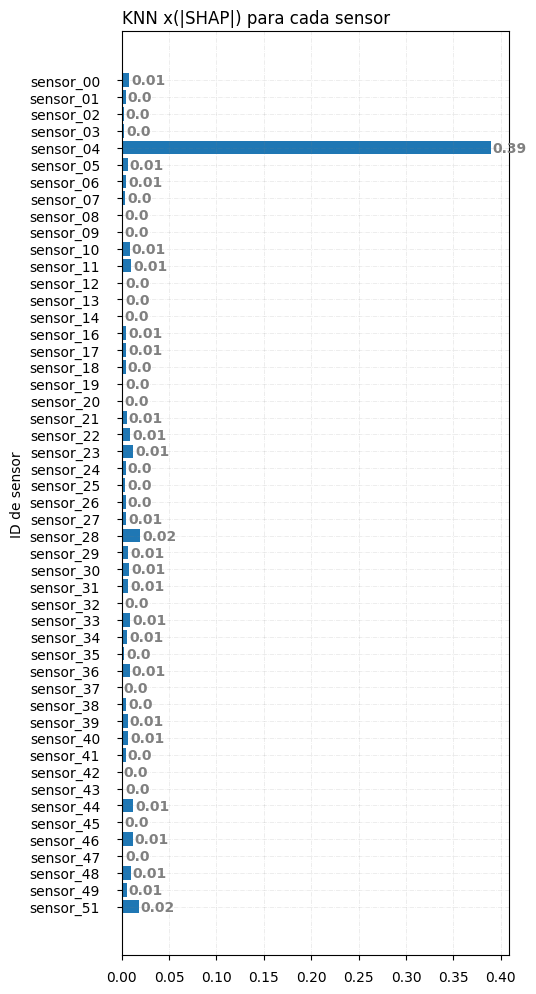

In [ ]:
# Mostrar el gráfico

# Este comando es lo mismo, pero sólo muestra los 20 primeros, para mantener consistencia muestro los 50 sensores.
# shap.summary_plot( shap_values , mySamples, feature_names = list(Xtrain.columns) )

variablesNames = list(Xtrain.columns)
currentPlotTitle = 'KNN x(|SHAP|) para cada sensor'

# Create the plot dataframe
barplotData = pd.DataFrame( np.zeros([len(sensorNames),2]) , columns = ['name', 'value'] )
barplotData.iloc[:,0] = variablesNames
barplotData.iloc[:,1] = vectorAbsMedias

# Figure Size
fig, ax = plt.subplots(figsize=(5, 12))

# Horizontal Bar Plot
plt.barh(barplotData.iloc[:,0],  barplotData.iloc[:,1])


# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=7)
ax.yaxis.set_tick_params(pad=12)

ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Show first values on top
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:

  currentOffset = 0.002
  currentW = i.get_width()
  if(currentW < 0): currentOffset = -0.005

  plt.text(i.get_width() + currentOffset, i.get_y() + 0.65,
           str(round((i.get_width()), 2)),
           fontsize=10, fontweight='bold',
           color='grey')


# Add Plot Title
ax.set_title(currentPlotTitle,loc='left', )
ax.set_ylabel("ID de sensor")

# Show Plot
plt.show()

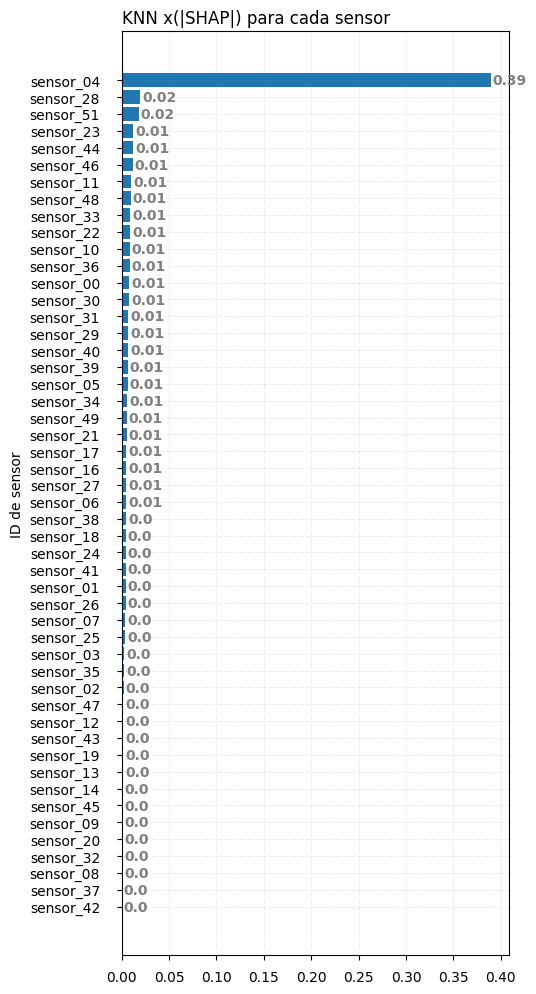

In [ ]:
# Sort the dataframe by the 'value' column in descending order
sortedData = barplotData.sort_values(by='value', ascending=False)

# Figure Size
fig, ax = plt.subplots(figsize=(5, 12))

# Horizontal Bar Plot
plt.barh(sortedData['name'], sortedData['value'])

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=7)
ax.yaxis.set_tick_params(pad=12)

ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)

# Show first values on top
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:
    currentOffset = 0.002
    currentW = i.get_width()
    if(currentW < 0): currentOffset = -0.005
    plt.text(i.get_width() + currentOffset, i.get_y() + 0.65,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title(currentPlotTitle, loc='left')
ax.set_ylabel("ID de sensor")

# Show Plot
plt.show()

[(*volver al índice*)](#indice)

<a name="randomforest"></a>
# Random Forest

Un árbol de decisión sobre un conjunto de datos corre el riesgo de hacer overfitting y que no sirva para datos nuevos. Para solucionar eso, se usa el modelo de random forest por mediante el cual se generan muchos árboles de decisión donde cada uno se ha entrenado con un sub-conjunto aleatorio del conjunto de datos total. Cada uno de los árboles da una solución posible y se selecciona la mejor mediante concenso.

Vídeo de introducción https://www.youtube.com/watch?v=GOJg3EE-nDM

Los random forest tienen la ventaja de ser un clasificador que funciona tanto para variables continuas como para variables discretas. Es un modelo robusto que soporta bien los datos con ruido y tiene una gran fiabilidad. Se distingue principalmente del resto de modelos en que tiene la mejor solución al problema de extración de importancia de variables.

Como contrapartida, aunque un random forest es mucho mejor que un árbol de decisión, tiende también al overfitting. Es difícil de interpretar dado que tienes que seguir no sólo un árbol de decisión si no varios a la vez. Y es computacionalmente muy costoso de entrenar tando en CPU como en memoria.


In [ ]:
# Copio los datos que tenemos en otros dataframes por si acaso se modifican
df_x     = pd.DataFrame(X)
df_y     = pd.DataFrame(Y)
y_new = df_y['new'].to_list() # Atención que aquí hay que convertir las y's en una lista primero.

# Dividimos los datos en conjunto de entrenamiento y test igual que antes
x_train, x_test, y_train, y_test = train_test_split(df_x, y_new, test_size= (1 - TRAIN_PROPORTION)) # Atención que elige la proporción complementariar a la anterior para dividir en 80% entrenamiento 20% test

randomforest = RandomForestClassifier(criterion='entropy')
randomforest.fit(x_train,y_train)

y_predict = randomforest.predict(x_test)

print(accuracy_score(y_test,y_predict))


0.9991796554552912


La disminución media de las impurezas (Mean Decrease of Impurity, MDI) [ https://doi.org/10.1023/a:1010933404324] es una medida utilizada en bosques aleatorios para cuantificar la importancia de cada característica en la predicción de una variable objetivo. Se calcula el MDI midiendo la importancia de cada variable, en cada árbol, y calculando cómo Se reduce la impureza. Cuando se utiliza una variable para dividir un nodo de árbol, se reduce la impureza de ese nodo, y la reducción de la impureza se correlaciona con la importancia de esa variable. El MDI de una característica se calcula promediando la reducción de impurezas en todos los árboles en los que se utiliza esa característica. Un MDI más alto significa más importancia.

In [ ]:
# Los valores MDI no dependen de ninguna simulación. Son únicos para el modelo y
# es una de las ventajas del Random Forest. Es muy fácil de explicar, pero suele
# ser peor en predicciones, o bien ser más sesgado en las predicciones.

# Creamos un vector donde almacenamos los valores MDI para cada uno de los sensores
vectorMedias    = randomforest.feature_importances_
vectorAbsMedias = randomforest.feature_importances_
vectorSigmas    = np.zeros(50)
vectorAbsSigmas = np.zeros(50)

# Y también lo guardamos para nuestra trabla final.
shapAverageData.iloc[:,3]    = vectorMedias
shapSigmaData.iloc[:,3]      = vectorSigmas
shapAbsAverageData.iloc[:,3] = vectorAbsMedias
shapAbsSigmaData.iloc[:,3]   = vectorAbsSigmas




In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


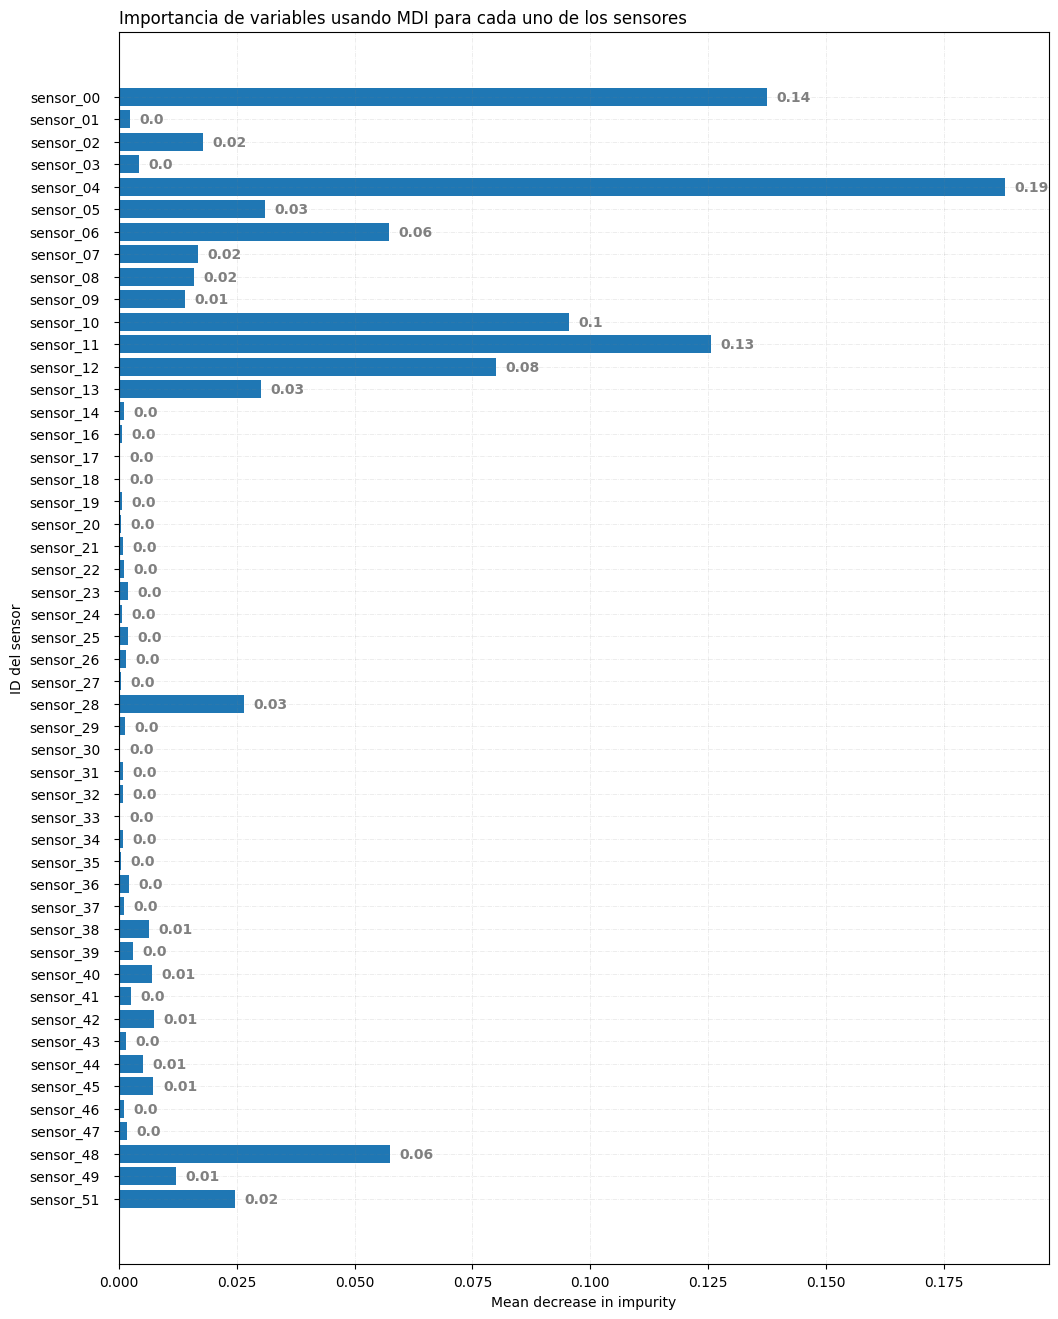

In [ ]:
barplotData = pd.DataFrame( np.zeros([len(X.columns),2]) )
barplotData[0] = X.columns
barplotData[1] = randomforest.feature_importances_

# Figure Size
fig, ax = plt.subplots(figsize=(12, 16))

# Horizontal Bar Plot
plt.barh(barplotData[0], barplotData[1])

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)

ax.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
# ---- Rótulos

# Show top values
ax.invert_yaxis()

# Add annotation to bars
for i in ax.patches:

    currentOffset = 0.002
    currentW = i.get_width()
    if(currentW < 0): currentOffset = -0.005

    plt.text(i.get_width() + currentOffset, i.get_y() + 0.6,
             str(round((i.get_width()), 2)),
             fontsize=10, fontweight='bold',
             color='grey')

# Add Plot Title
ax.set_title('Importancia de variables usando MDI para cada uno de los sensores',
             loc='left', )

ax.set_xlabel("Mean decrease in impurity")
ax.set_ylabel("ID del sensor")

# Show Plot
plt.show()

In [ ]:
# Hacemos lo mismo del SHAP pero para Random Forest
explainerRF = shap.Explainer(randomforest, x_train)

# Get the values of the test set
shap_valuesRF = explainerRF(x_test, check_additivity=False)
myShapValuesRF = shap_valuesRF.values.tolist()

 93%|=================== | 2261/2438 [00:12<00:00]       

In [ ]:
print(len(myShapValuesRF))
print(myShapValuesRF[0])
print(len(shap_valuesRF.values))
print(shap_valuesRF.values[0])

1219
[[0.1277755143217655, -0.12777551396167838], [-0.0029170236256322825, 0.002917023832851555], [-0.008254999851051253, 0.008255000034405385], [0.0018711903394432738, -0.001871190434321761], [0.1443270235248201, -0.14432702058795258], [0.05493226038233843, -0.05493226185964886], [0.02408535683673108, -0.02408535716269398], [-0.007147380940441508, 0.007147380954702385], [0.007157619016070384, -0.007157619209028781], [0.006356348794688529, -0.00635634901242156], [0.04981944346189266, -0.04981944361803471], [0.07300825349928346, -0.07300825255166274], [0.040235356301709546, -0.04023535726184491], [0.020035238165582996, -0.020035237599222454], [0.0017602380955941044, -0.001760238088609185], [0.0012088095225044526, -0.0012088095417129808], [-1.678571235970594e-05, 1.6785712941782548e-05], [-0.00019476190267596393, 0.00019476190936984494], [0.0013334523829689716, -0.0013334523887897375], [0.0005441666890692432, -0.0005441666550177615], [0.002434047567367088, -0.0024340476232464427], [0.001

In [ ]:
# Creamos un vector donde almacenamos los valores SHAP para cada uno de los sensores
vectorMedias    = np.mean(shap_valuesRF.values, axis=0)
vectorAbsMedias = np.mean(np.absolute(shap_valuesRF.values), axis=0)
vectorSigmas    = np.std(shap_valuesRF.values, axis=0)
vectorAbsSigmas = np.std(np.absolute(shap_valuesRF.values), axis=0)

# Y también lo guardamos para nuestra trabla final.
shapAverageData.iloc[:,2]    = vectorMedias[:,:1]
shapSigmaData.iloc[:,2]      = vectorSigmas[:,:1]
shapAbsAverageData.iloc[:,2] = vectorAbsMedias[:,:1]
shapAbsSigmaData.iloc[:,2]   = vectorAbsSigmas[:,:1]

Tabla comparatoria con peso de variables y IQR de fiabilidad, incluir referencias en la tabla

In [ ]:
print(shapAbsAverageData)
print(type(shapAbsAverageData))

    ANN_SHAP  KNN_SHAP  RandomForest_SHAP  RandomForest_MDI  PLS  AF-RL
0          0         0           0.104665          0.137420    0      0
1          0         0           0.005095          0.002292    0      0
2          0         0           0.006710          0.017755    0      0
3          0         0           0.003612          0.004220    0      0
4          0         0           0.130390          0.187844    0      0
5          0         0           0.039342          0.031008    0      0
6          0         0           0.029680          0.057301    0      0
7          0         0           0.003078          0.016836    0      0
8          0         0           0.006081          0.015929    0      0
9          0         0           0.002838          0.014009    0      0
10         0         0           0.047425          0.095521    0      0
11         0         0           0.055821          0.125626    0      0
12         0         0           0.035257          0.079894    0

In [ ]:
heatmapDF = heatmapDF.drop(heatmapDF.columns[[6]], axis=1)

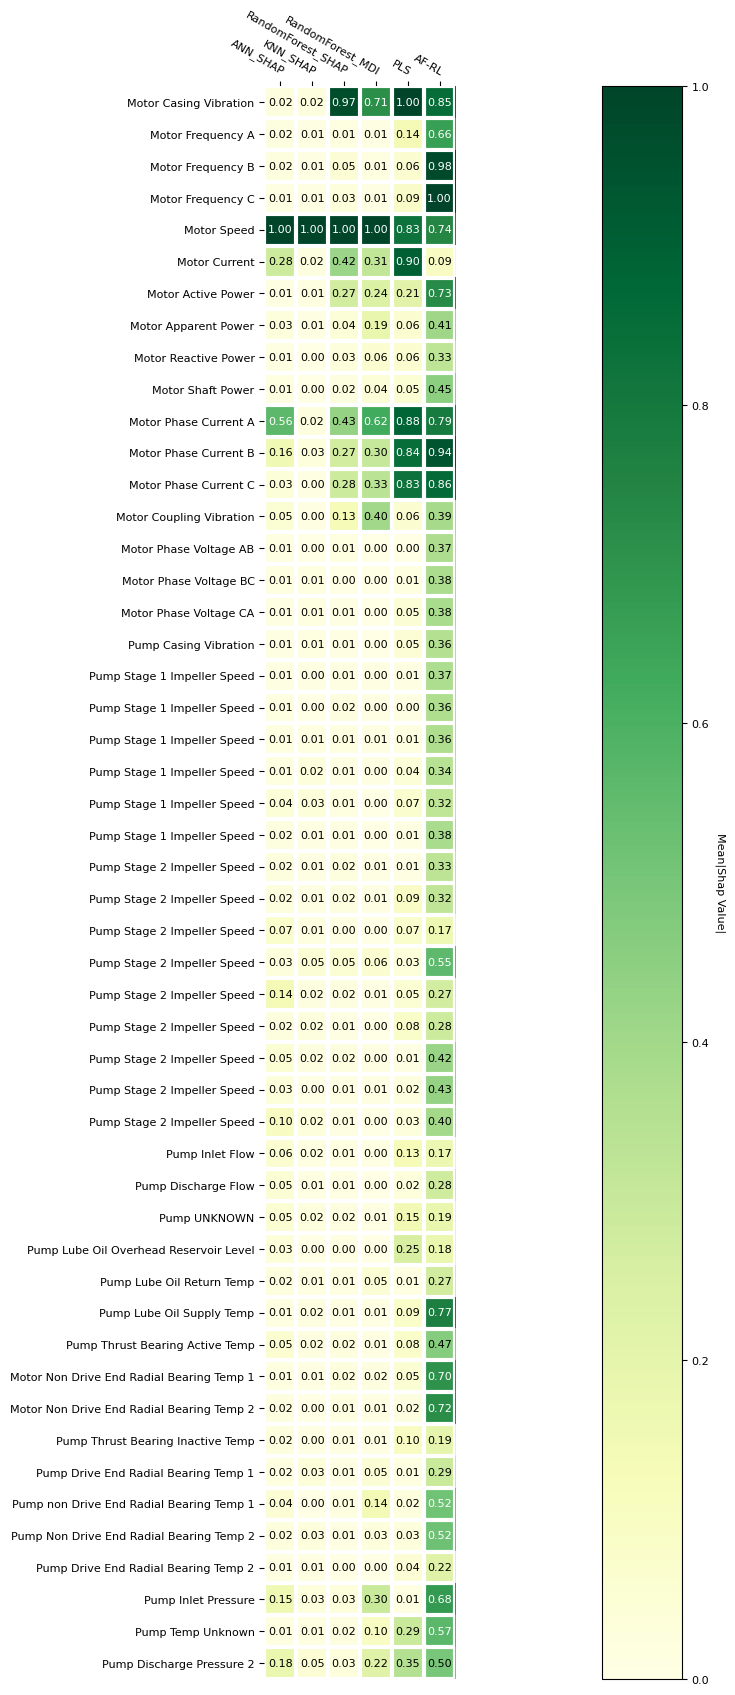

In [ ]:
# Show the SHAP heatmaps

# ----------------------------------
# Absolute
# ----------------------------------

# Prepare the data to do a heatmap of the normalzed SHAP values
heatmapDF = shapAbsAverageData.copy()
#heatmapDF = heatmapDF.drop(heatmapDF.columns[[5]], axis=1)

# Normalize by columns
for j in range( len(heatmapDF.columns)):

  # Get the column maximum
  currentMax = max(heatmapDF.iloc[:,j].to_list())

  for i in range(heatmapDF.shape[0]):

    heatmapDF.iloc[i,j] = heatmapDF.iloc[i,j]/currentMax


#print(heatmapDF)

# Datos del heatmap
a = heatmapDF.to_numpy().astype(float)

# Nombre de cada una de las filas (sensores)
b = sensorProperties

# Nombre de las columnas
c = heatmapDF.columns.values.tolist()


fig, ax = plt.subplots()

im, cbar = heatmap(a, b, c, ax=ax, cmap="YlGn", cbarlabel="Mean|Shap Value|")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
fig.set_size_inches(30.5, 20.5)
plt.rcParams.update({'font.size': 8})
plt.show()


In [ ]:
import matplotlib as mpl

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    #plt.rcParams.update({'font.size': 15})

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)



    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts